In [2]:
import json
import os
import torch

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from collections import defaultdict
from datetime import datetime
from pathlib import Path

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


In [3]:
def plot_MI_planes(MI_X_L: dict, MI_L_Y: dict, filtered_MI_X_L: dict=None, filtered_MI_L_Y: dict=None,
                   n_columns: int=3) -> None:
    """
    Plot information plane data for each layer in a subplot.
    
    Parameters
    ----------
    MI_X_L : dict
        Raw I(X;L) data (with errorbars).
    MI_L_Y : dict
        Raw I(L;Y) data (with errorbars).
    filtered_MI_X_L : dict
        Filtered I(X;L) data.
    filtered_MI_L_Y : dict
        Filtered I(L;Y) data.
    """
    
    assert len(MI_X_L) == len(MI_L_Y)
    
    filtered_provided = (not filtered_MI_X_L is None) and (not filtered_MI_L_Y is None)
    
    # Number of rows.
    n_rows = len(MI_X_L) // n_columns + (len(MI_X_L) % n_columns != 0)
    
    width = 6
    height = 4
    fig, ax = plt.subplots(n_rows, n_columns, figsize=(width * n_columns, height * n_rows))
    for index, layer_name in enumerate(MI_X_L.keys()):
        row_index = index // n_columns
        column_index = index % n_columns
        subplot_ax = ax[row_index, column_index]
        
        subplot_ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
        subplot_ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
        subplot_ax.set_title(str(layer_name))
        
        x =     [item[0] for item in MI_X_L[layer_name]]
        x_err = [item[1] for item in MI_X_L[layer_name]]
        y =     [item[0] for item in MI_L_Y[layer_name]]
        y_err = [item[1] for item in MI_L_Y[layer_name]]
        
        if filtered_provided:
            subplot_ax.errorbar(x, y, x_err, y_err, ls='none', solid_capstyle='projecting', capsize=3, alpha=0.25, color='lightblue')
            subplot_ax.plot(filtered_MI_X_L[layer_name], filtered_MI_L_Y[layer_name], color='red')
        else:
            subplot_ax.plot(x, y)
            #subplot_ax.scatter(x, y, cmap=list(range(len(x))))
            
    plt.show();

In [4]:
# steps_100k = pd.read_csv(r"v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_5.0_2023_12_21-13_43_31.csv").Step.values.tolist()
# steps_100k = list(map(str, steps_100k))
steps_100k = '0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,40,50,60,70,80,90,100,110,120,130,140,160,240,320,400,480,560,640,667,720,800,880,960,1334,2001,2668,3335,4002,4669,5336,6003,6670,7337,8004,8671,9338,10005,10672,11339,12006,12673,13340,14007,14674,15341,16008,16675,17342,18009,18676,19343,20010,20677,21344,22011,22678,23345,24012,24679,25346,26013,26680,27347,28014,28681,29348,30015,30682,31349,32016,32683,33350,34017,34684,35351,36018,36685,37352,38019,38686,39353,40020,40687,41354,42021,42688,43355,44022,44689,45356,46023,46690,47357,48024,48691,49358,50025,50692,51359,52026,52693,53360,54027,54694,55361,56028,56695,57362,58029,58696,59363,60030,60697,61364,62031,62698,63365,64032,64699,65366,66033,66700,67367,68034,68701,69368,70035,70702,71369,72036,72703,73370,74037,74704,75371,76038,76705,77372,78039,78706,79373,80040,80707,81374,82041,82708,83375,84042,84709,85376,86043,86710,87377,88044,88711,89378,90045,90712,91379,92046,92713,93380,94047,94714,95381,96048,96715,97382,98049,98716,99383'
steps_100k = list(map(int, steps_100k.split(',')))
steps = steps_100k

# Reading data from TBoard

In [5]:
logs_dir = r".\logs"

In [6]:
os.listdir(logs_dir)

['v31-mlp3-wd1e-2-TEST-multipleinonenote',
 'v32-mlp3-steps100k-trainpts1k-alpha8--ITER_WD_0.001',
 'v32-mlp3-steps100k-trainpts1k-alpha8--ITER_WD_0.005',
 'v32-mlp3-steps100k-trainpts1k-alpha8--ITER_WD_0.05',
 'v32-mlp3-steps100k-trainpts1k-alpha8--ITER_WD_0.1',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_1.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_2.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_3.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_4.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_5.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_6.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_7.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.0001',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.0004',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.0008',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.002',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.006

In [7]:
log_folders = {}

prefixes = {}
prefixes['alpha'] = "v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA"

log_folders['alpha'] = [dir_ for dir_ in os.listdir(logs_dir) if dir_.startswith(prefixes['alpha'])]

In [8]:
log_folders['alpha']

['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_1.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_2.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_3.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_4.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_5.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_6.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_7.0',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']

In [16]:
events_dd = {}

for filename in log_folders['alpha']:
    filepath = os.path.join(logs_dir, filename)
    filepath_plus = os.path.join(filepath, os.listdir(os.path.join(logs_dir, filename))[0])
    events_dd[filename] = EventAccumulator(filepath_plus)
    
for event_acc in events_dd.values():
    event_acc.Reload();

In [17]:
events_dd

{'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_1.0': <tensorboard.backend.event_processing.event_accumulator.EventAccumulator at 0x1ea4ccea040>,
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_2.0': <tensorboard.backend.event_processing.event_accumulator.EventAccumulator at 0x1ea4ccea6a0>,
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_3.0': <tensorboard.backend.event_processing.event_accumulator.EventAccumulator at 0x1ea4cce0e50>,
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_4.0': <tensorboard.backend.event_processing.event_accumulator.EventAccumulator at 0x1ea4cd351f0>,
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_5.0': <tensorboard.backend.event_processing.event_accumulator.EventAccumulator at 0x1ea4cd35940>,
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_6.0': <tensorboard.backend.event_processing.event_accumulator.EventAccumulator at 0x1ea4cd370d0>,
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_7.0': <tensorboard.backend.event_processing.event_accum

In [18]:
cols_df = next(iter(events_dd.values())).Tags()['scalars']
cols_df

['Loss/train',
 'Loss/test',
 'Acc/train',
 'Acc/test',
 'WN/All',
 'WN/Last layer',
 'MI(X;L)/layer 1',
 'MI(L;Y)/layer 1',
 'MI-Errors/layer 1',
 'MI(X;L)/layer 2',
 'MI(L;Y)/layer 2',
 'MI-Errors/layer 2',
 'MI(X;L)/layer 3',
 'MI(L;Y)/layer 3',
 'MI-Errors/layer 3']

In [19]:
logs_dd = {}
logs_df = {}

for name, event in events_dd.items():
    logs_dd[name] = {}
    for col_ in cols_df:
        logs_dd[name][col_] = list(map(lambda x: x.value, event.Scalars(col_)))

In [20]:
for key, val in logs_dd.items():
    reval = {}
    for k, v in val.items():
        if not k.startswith('MI-Errors'):
            reval[k] = v
    logs_df[key] = pd.DataFrame(data=reval)

In [21]:
logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_1.0']

Loss/train  Loss/test  Acc/train  Acc/test     WN/All  WN/Last layer  \
0      1.203998   1.234048      0.068    0.0650  11.708156       8.185809   
1      0.857949   0.868548      0.335    0.2928  11.712702       8.187582   
2      0.780323   0.797153      0.488    0.4992  11.724092       8.191775   
3      0.702165   0.727328      0.618    0.5947  11.736138       8.196212   
4      0.623296   0.657702      0.727    0.6612  11.748734       8.200380   
..          ...        ...        ...       ...        ...            ...   
197    0.000008   0.273479      1.000    0.8575  27.104727      12.425606   
198    0.000004   0.270066      1.000    0.8586  27.013992      12.407133   
199    0.000013   0.264691      1.000    0.8633  26.905210      12.378322   
200    0.000014   0.262405      1.000    0.8616  26.805092      12.360854   
201    0.000005   0.265584      1.000    0.8606  26.682285      12.329284   

     MI(X;L)/layer 1  MI(L;Y)/layer 1  MI(X;L)/layer 2  MI(L;Y)/layer 2  \
0           2.650820         1.265010         2.305704         1.113951   
1           2.456501         1.213945         2.284900         1.156672   
2           2.801338         1.323785         2.492882         1.255148   
3           2.957136         1.416432         2.479833         1.324402   
4           3.101591         1.411504         2.590926         1.397929   
..               ...              ...              ...              ...   
197         2.460793         2.093682              NaN              NaN   
198         2.773878         2.208587              NaN              NaN   
199         2.592056         2.188213              NaN              NaN   
200         2.600571         2.200278              NaN              NaN   
201         2.632212         2.158313              NaN              NaN   

     MI(X;L)/layer 3  MI(L;Y)/layer 3  
0           0.472103         0.687793  
1           0.684986         0.836217  
2           1.717739         1.114648  
3           2.314747         1.375298  
4           2.776238         1.491031  
..               ...              ...  
197              NaN              NaN  
198              NaN              NaN  
199              NaN              NaN  
200              NaN              NaN  
201              NaN              NaN  

[202 rows x 12 columns]

In [22]:
logs_df.keys()

dict_keys(['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_1.0', 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_2.0', 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_3.0', 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_4.0', 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_5.0', 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_6.0', 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_7.0', 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0'])

# Plots - Alpha

In [36]:
import matplotlib.pylab as pylab
params = {
#     'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

##  Planes

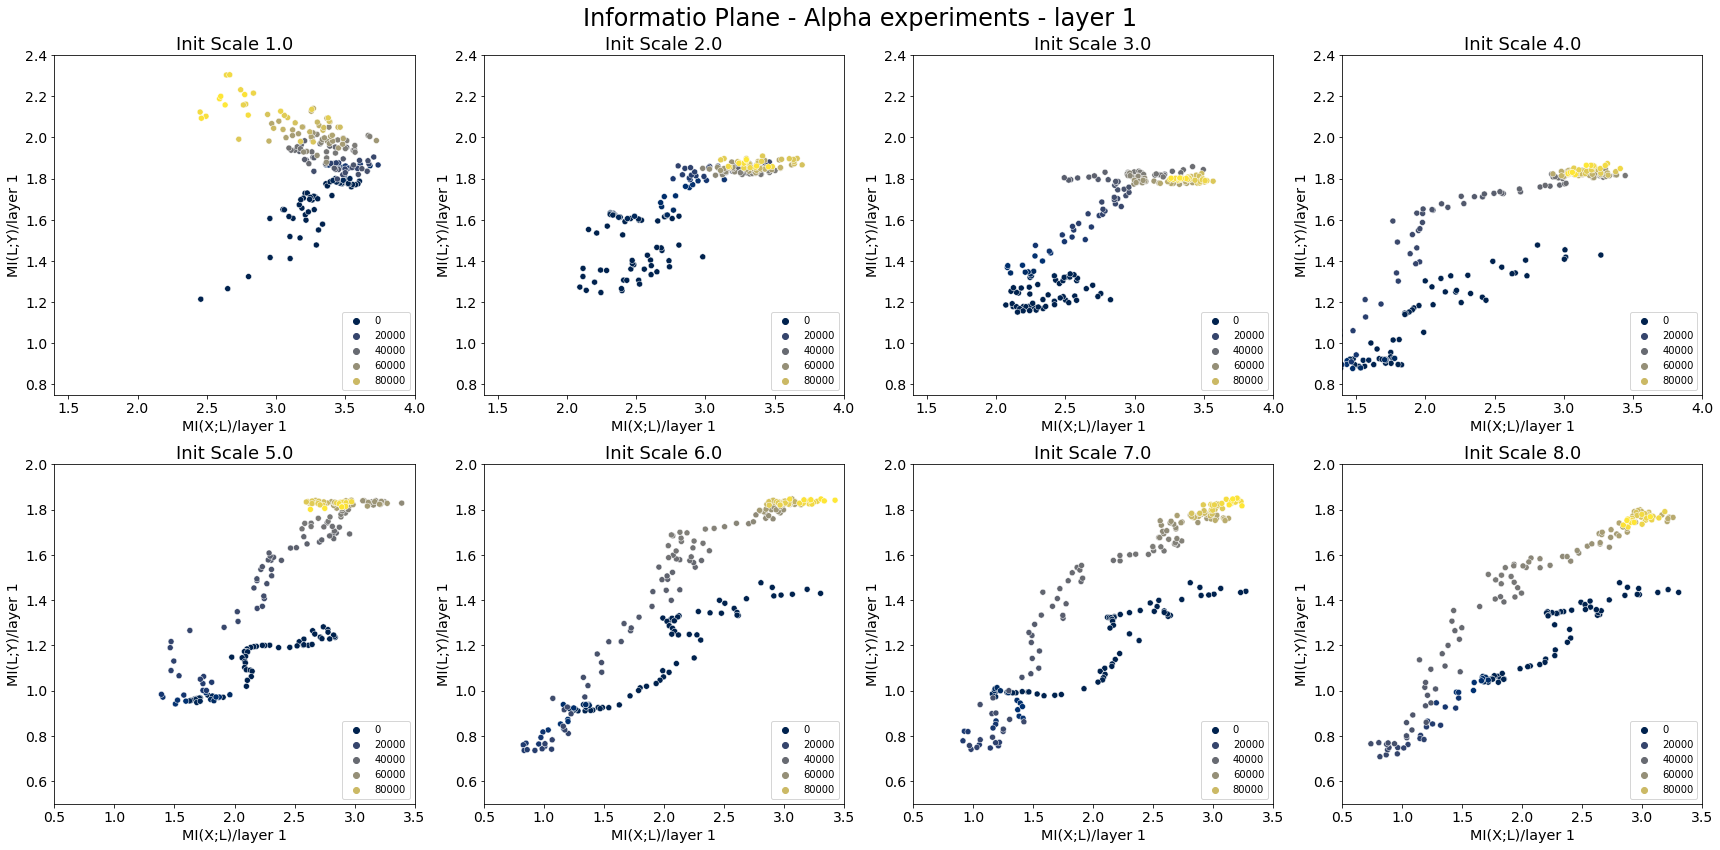

In [37]:
fig, axs2d = plt.subplots(2, 4, figsize=(12*2,6*2), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 1', 
        y=f'MI(L;Y)/layer 1',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"Init Scale {df_name.split('_')[-1]}", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    if plot_i < 4:
        axs_rav[plot_i].set_xlim(1.4, 4)
        axs_rav[plot_i].set_ylim(0.75, 2.4)
    else:
        axs_rav[plot_i].set_xlim(0.5, 3.5)
        axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Informatio Plane - Alpha experiments - layer 1', fontsize=24)
plt.tight_layout()
plt.show()

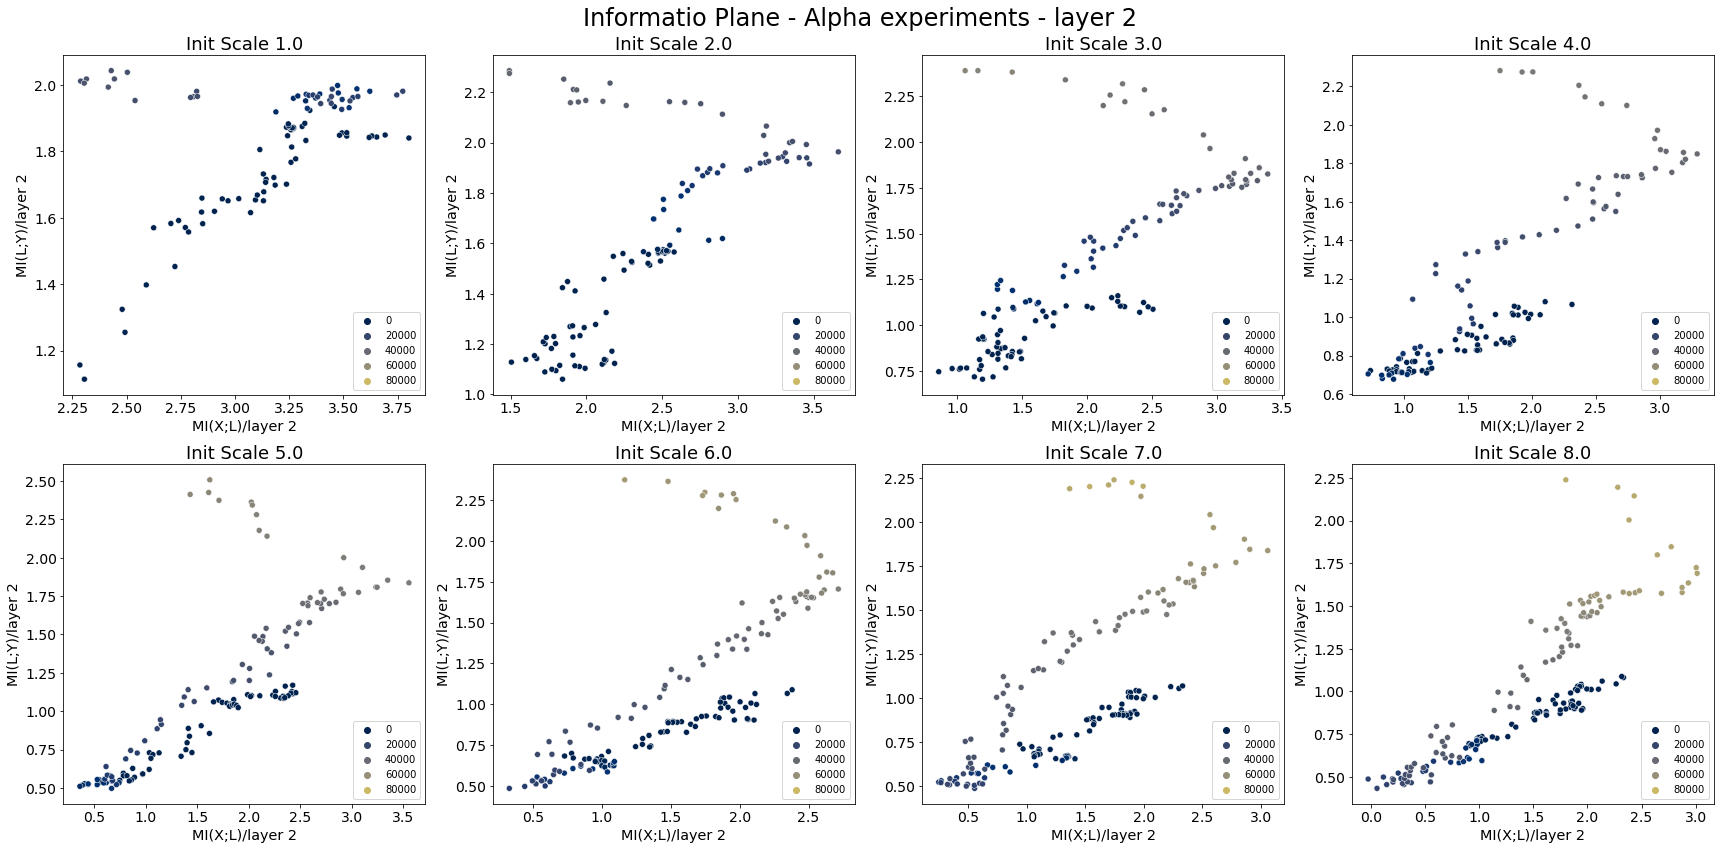

In [38]:
fig, axs2d = plt.subplots(2, 4, figsize=(12*2,6*2), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 2', 
        y=f'MI(L;Y)/layer 2',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"Init Scale {df_name.split('_')[-1]}", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Informatio Plane - Alpha experiments - layer 2', fontsize=24)
plt.tight_layout()
plt.show()

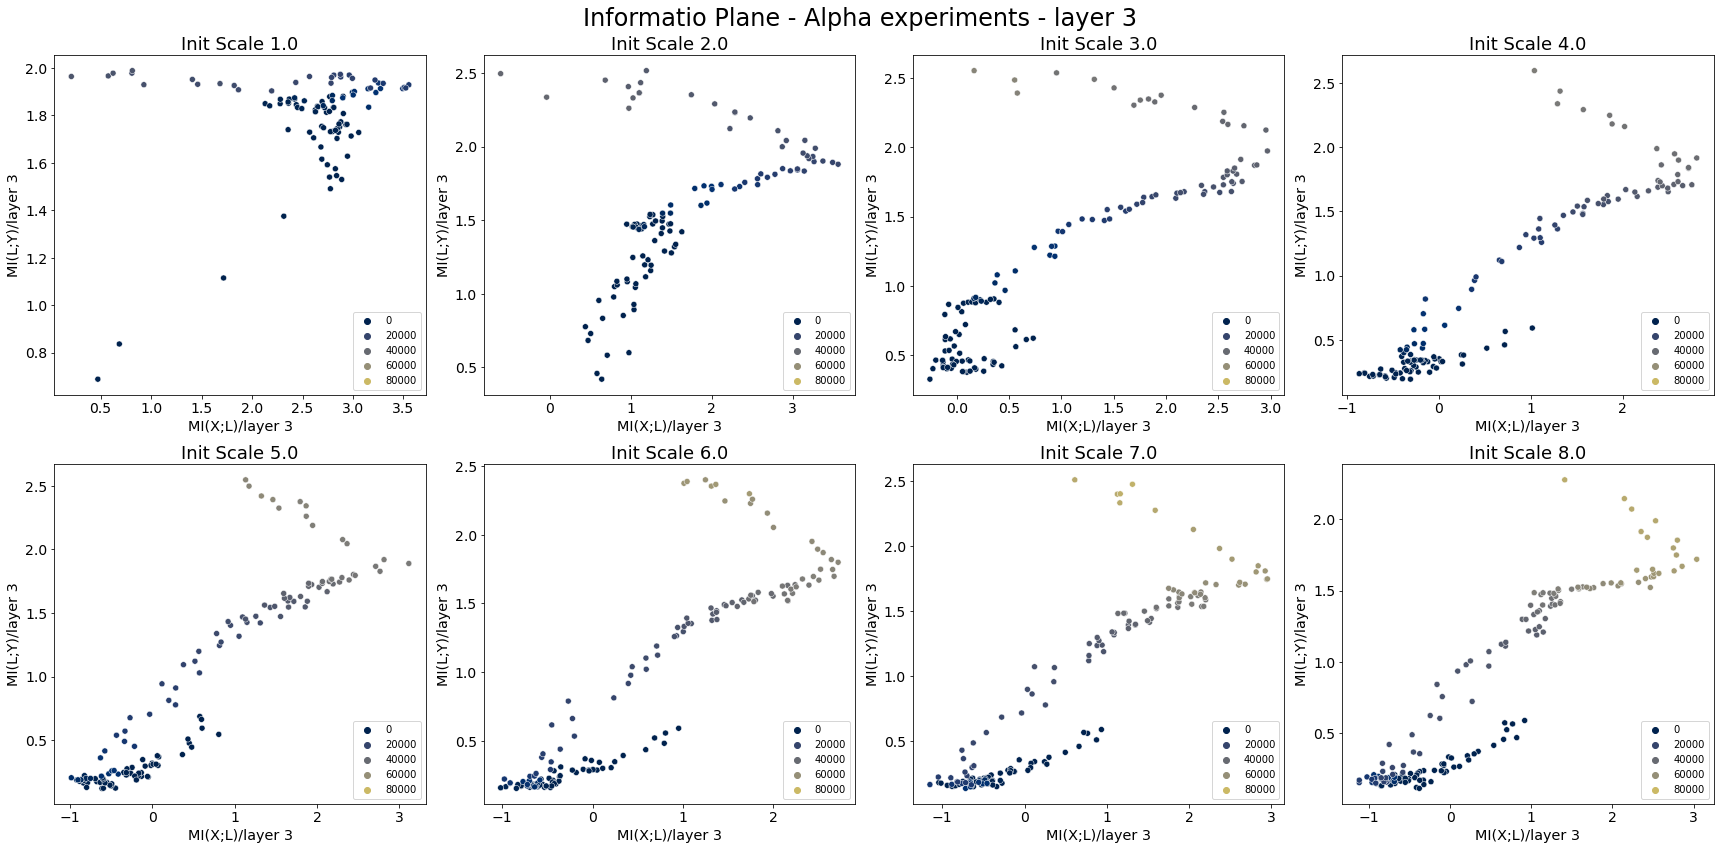

In [39]:
fig, axs2d = plt.subplots(2, 4, figsize=(12*2,6*2), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 3', 
        y=f'MI(L;Y)/layer 3',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"Init Scale {df_name.split('_')[-1]}", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Informatio Plane - Alpha experiments - layer 3', fontsize=24)
plt.tight_layout()
plt.show()

### No hue - line

In [64]:
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 1'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 1'].values
# )
# plt.show()
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 2'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 2'].values
# )
# plt.show()
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 3'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 3'].values
# )
# plt.show()


### Loss

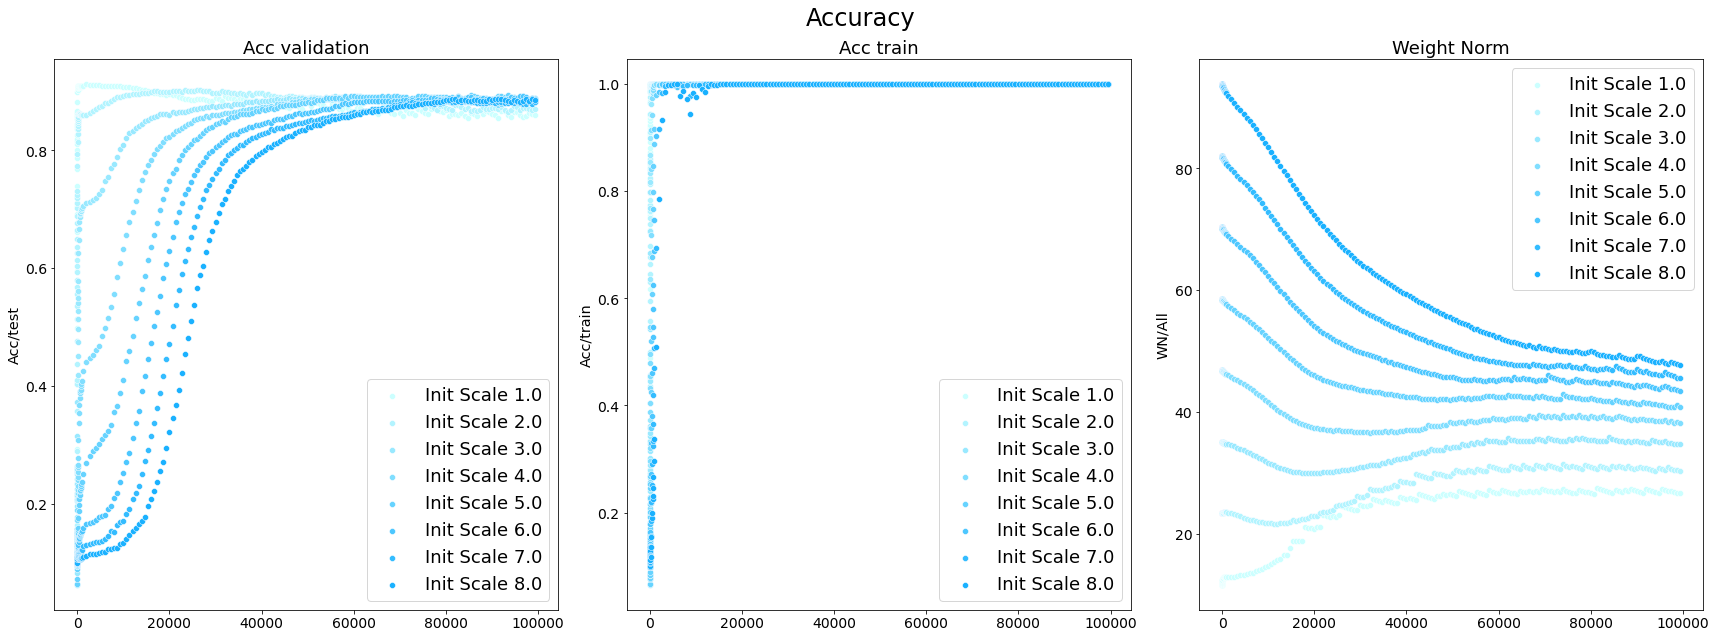

In [40]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,9), )

axs_rav = np.ravel(axs2d)

rgb_0 = (0, 166/255, 255/255)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
             
    hue_i = 8-plot_i
    rgb_i = (0.8*hue_i/8 , rgb_0[1]+89/255*hue_i/8, rgb_0[2])
    plot_i = 0
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="Acc/test",
        ax=axs_rav[0],
        color = [rgb_i],
        label=f"Init Scale {df_name.split('_')[-1]}"
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=18)
    axs_rav[plot_i].set_title(f"Acc validation", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="Acc/train",
        ax=axs_rav[1],
        color = [rgb_i],
        label=f"Init Scale {df_name.split('_')[-1]}"
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=18)
    axs_rav[plot_i+1].set_title(f"Acc train", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="WN/All",
        ax=axs_rav[2],
        color = [rgb_i],
        label=f"Init Scale {df_name.split('_')[-1]}"
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='upper right', fontsize=18)
    axs_rav[plot_i+2].set_title(f"Weight Norm", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('Accuracy', fontsize=24)
plt.tight_layout()
plt.show()

## MI over steps

### mi x l

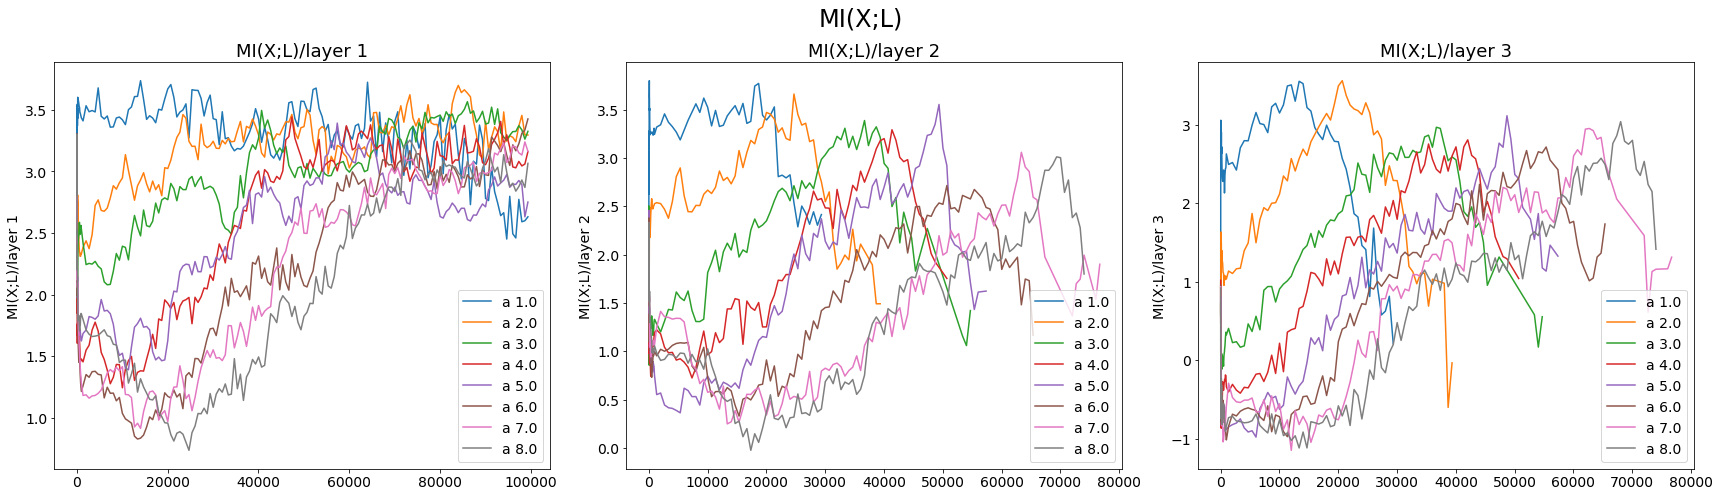

In [41]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,7), )

axs_rav = np.ravel(axs2d)

rgb_0 = (0, 166/255, 255/255)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
             
    hue_i = 8-plot_i
    rgb_i = (0.8*hue_i/8 , rgb_0[1]+89/255*hue_i/8, rgb_0[2])
    plot_i = 0
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 1",
        ax=axs_rav[0],
#         color = [rgb_i],
        label=f"a {df_name.split('_')[-1]}"
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i].set_title(f"MI(X;L)/layer 1", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 2",
        ax=axs_rav[1],
#         color = [rgb_i],
        label=f"a {df_name.split('_')[-1]}"
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+1].set_title(f"MI(X;L)/layer 2", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 3",
        ax=axs_rav[2],
#         color = [rgb_i],
        label=f"a {df_name.split('_')[-1]}"
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+2].set_title(f"MI(X;L)/layer 3", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('MI(X;L)', fontsize=24)
plt.tight_layout()
plt.show()

###  mi l y 

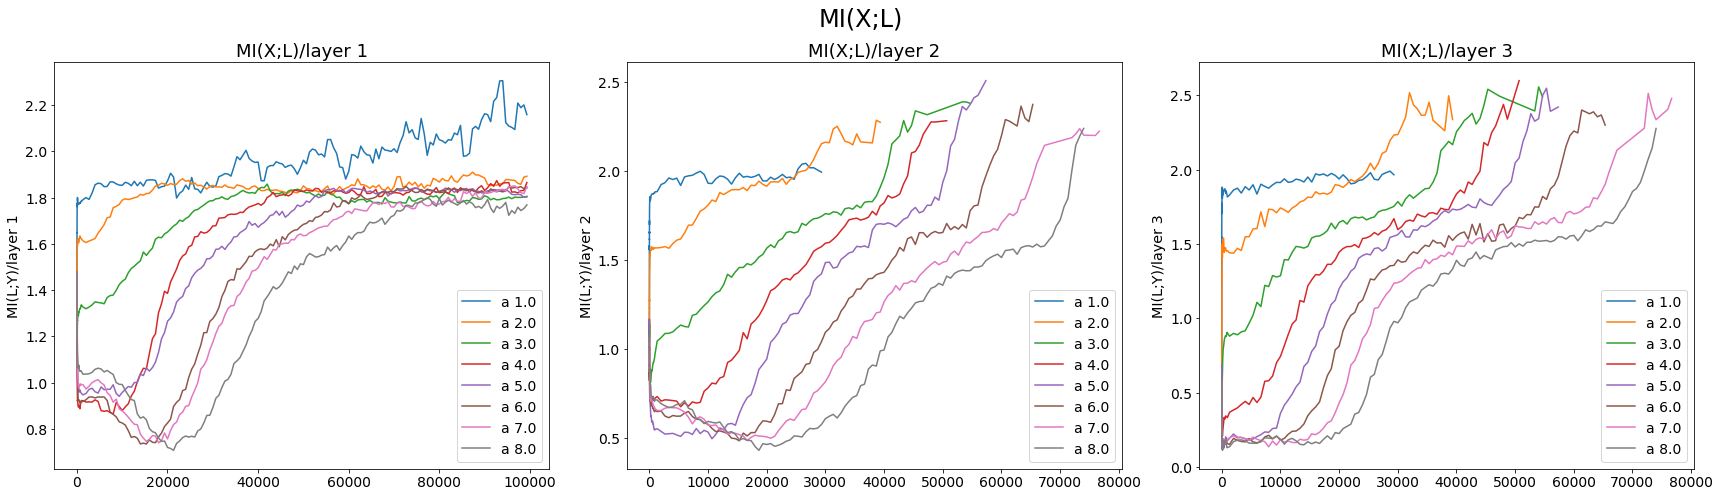

In [44]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,7), )

axs_rav = np.ravel(axs2d)

rgb_0 = (0, 166/255, 255/255)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
             
    hue_i = 8-plot_i
    rgb_i = (0.8*hue_i/8 , rgb_0[1]+89/255*hue_i/8, rgb_0[2])
    plot_i = 0
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 1",
        ax=axs_rav[0],
#         color = [rgb_i],
        label=f"a {df_name.split('_')[-1]}"
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i].set_title(f"MI(X;L)/layer 1", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 2",
        ax=axs_rav[1],
#         color = [rgb_i],
        label=f"a {df_name.split('_')[-1]}"
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+1].set_title(f"MI(X;L)/layer 2", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 3",
        ax=axs_rav[2],
#         color = [rgb_i],
        label=f"a {df_name.split('_')[-1]}"
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+2].set_title(f"MI(X;L)/layer 3", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('MI(X;L)', fontsize=24)
plt.tight_layout()
plt.show()

# Plots - WD

In [108]:
log_folders = {}

prefixes = {}
prefixes['wd'] = "v32-mlp3-steps100k-trainpts1k-alpha8--ITER_WD"

log_folders['wd'] = [dir_ for dir_ in os.listdir(logs_dir) if dir_.startswith(prefixes['wd'])]

In [109]:
log_folders['wd'] = log_folders['wd'][:2] + ['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0'] + log_folders['wd'][2:]

In [110]:
events_dd = {}

for filename in log_folders['wd']:
    filepath = os.path.join(logs_dir, filename)
    filepath_plus = os.path.join(filepath, os.listdir(os.path.join(logs_dir, filename))[0])
    events_dd[filename] = EventAccumulator(filepath_plus)
    
for event_acc in events_dd.values():
    event_acc.Reload();
    
cols_df = next(iter(events_dd.values())).Tags()['scalars']
cols_df

logs_dd = {}
logs_df = {}

for name, event in events_dd.items():
    logs_dd[name] = {}
    for col_ in cols_df:
        logs_dd[name][col_] = list(map(lambda x: x.value, event.Scalars(col_)))
        
for key, val in logs_dd.items():
    reval = {}
    for k, v in val.items():
        if not k.startswith('MI-Errors'):
            reval[k] = v
    logs_df[key] = pd.DataFrame(data=reval)

In [111]:
import matplotlib.pylab as pylab
params = {
#     'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

##  Planes

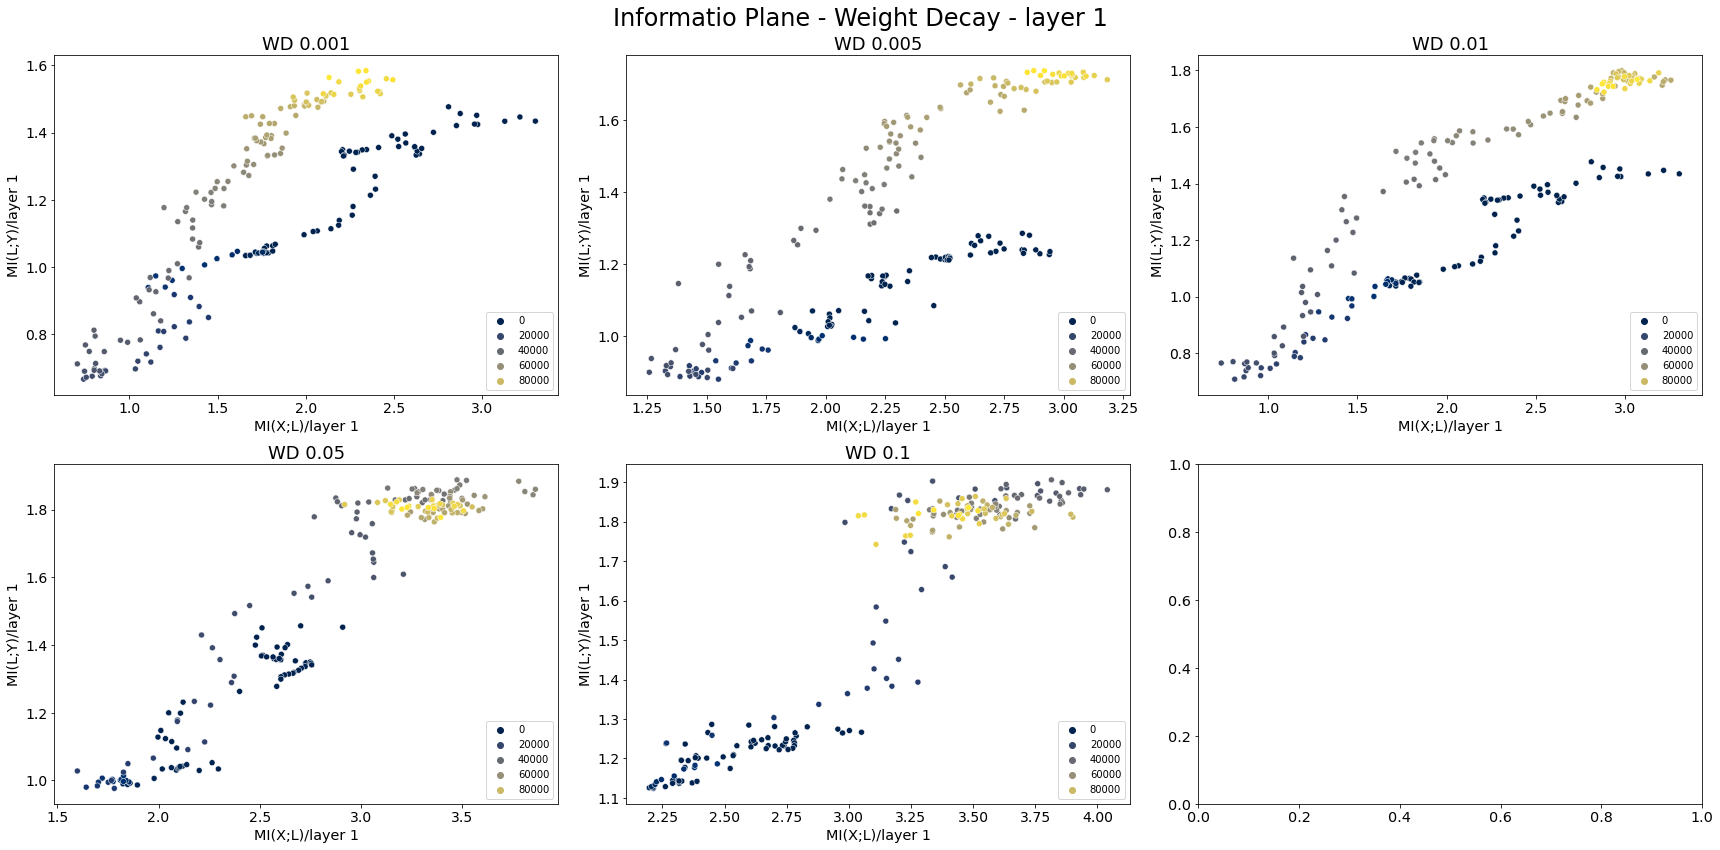

In [131]:
fig, axs2d = plt.subplots(2, 3, figsize=(12*2,6*2), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 1', 
        y=f'MI(L;Y)/layer 1',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"WD {df_name.split('_')[-1]}", fontsize=18)
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        axs_rav[plot_i].set_title(f"WD 0.01", fontsize=18)    
        
    
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Informatio Plane - Weight Decay - layer 1', fontsize=24)
plt.tight_layout()
plt.show()

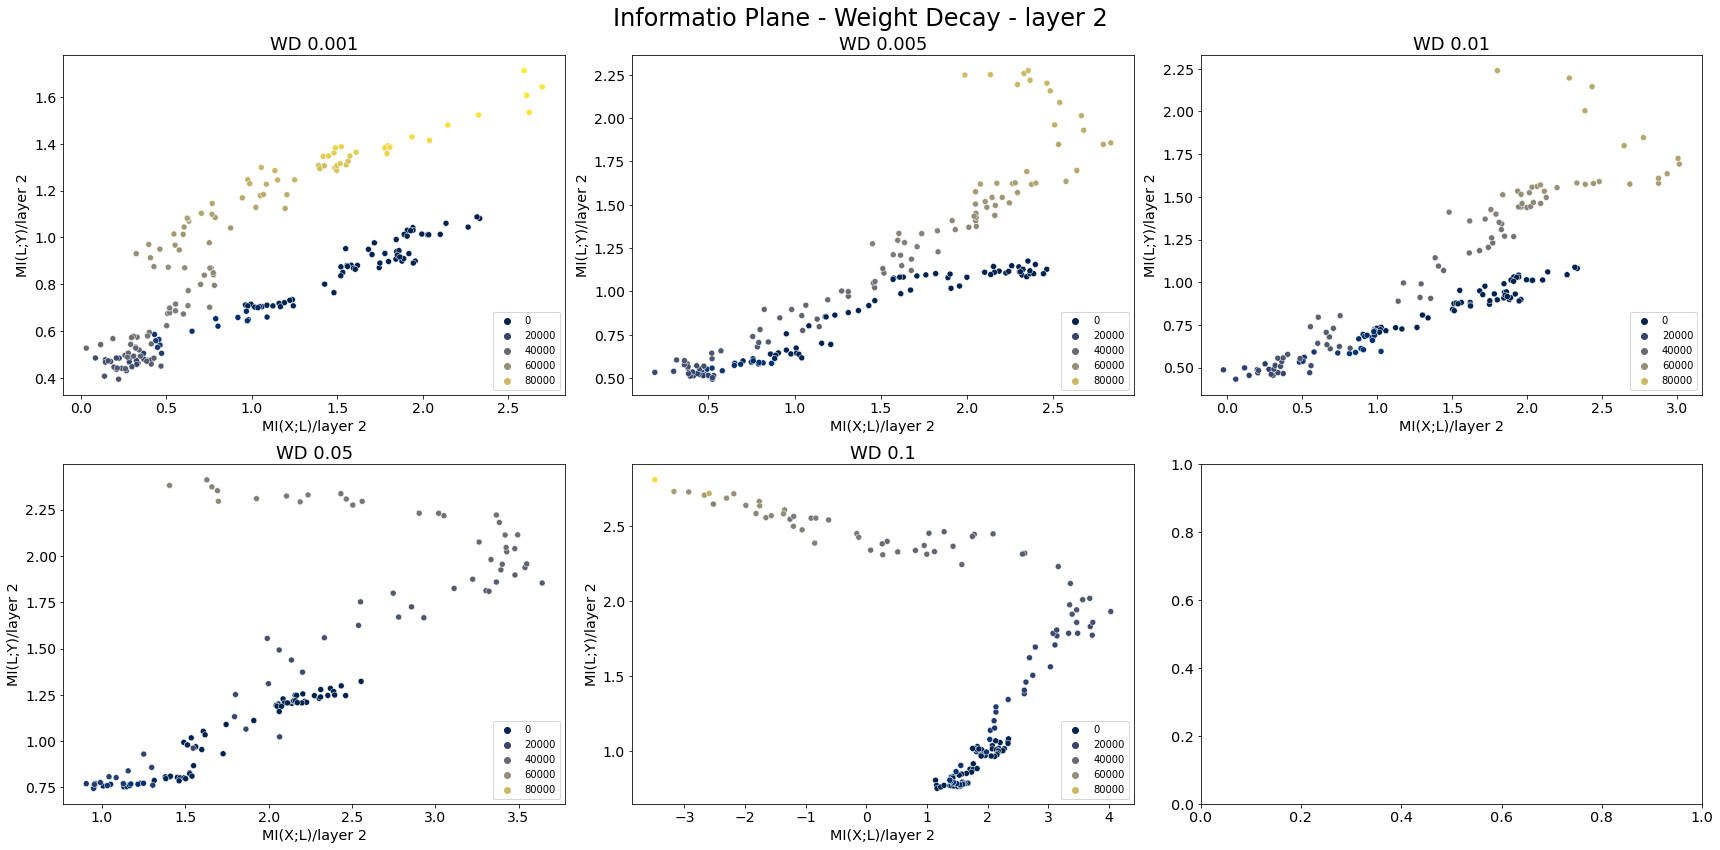

In [132]:
fig, axs2d = plt.subplots(2, 3, figsize=(12*2,6*2), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 2', 
        y=f'MI(L;Y)/layer 2',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"WD {df_name.split('_')[-1]}", fontsize=18)
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        axs_rav[plot_i].set_title(f"WD 0.01", fontsize=18)    
        
    
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Informatio Plane - Weight Decay - layer 2', fontsize=24)
plt.tight_layout()
plt.show()

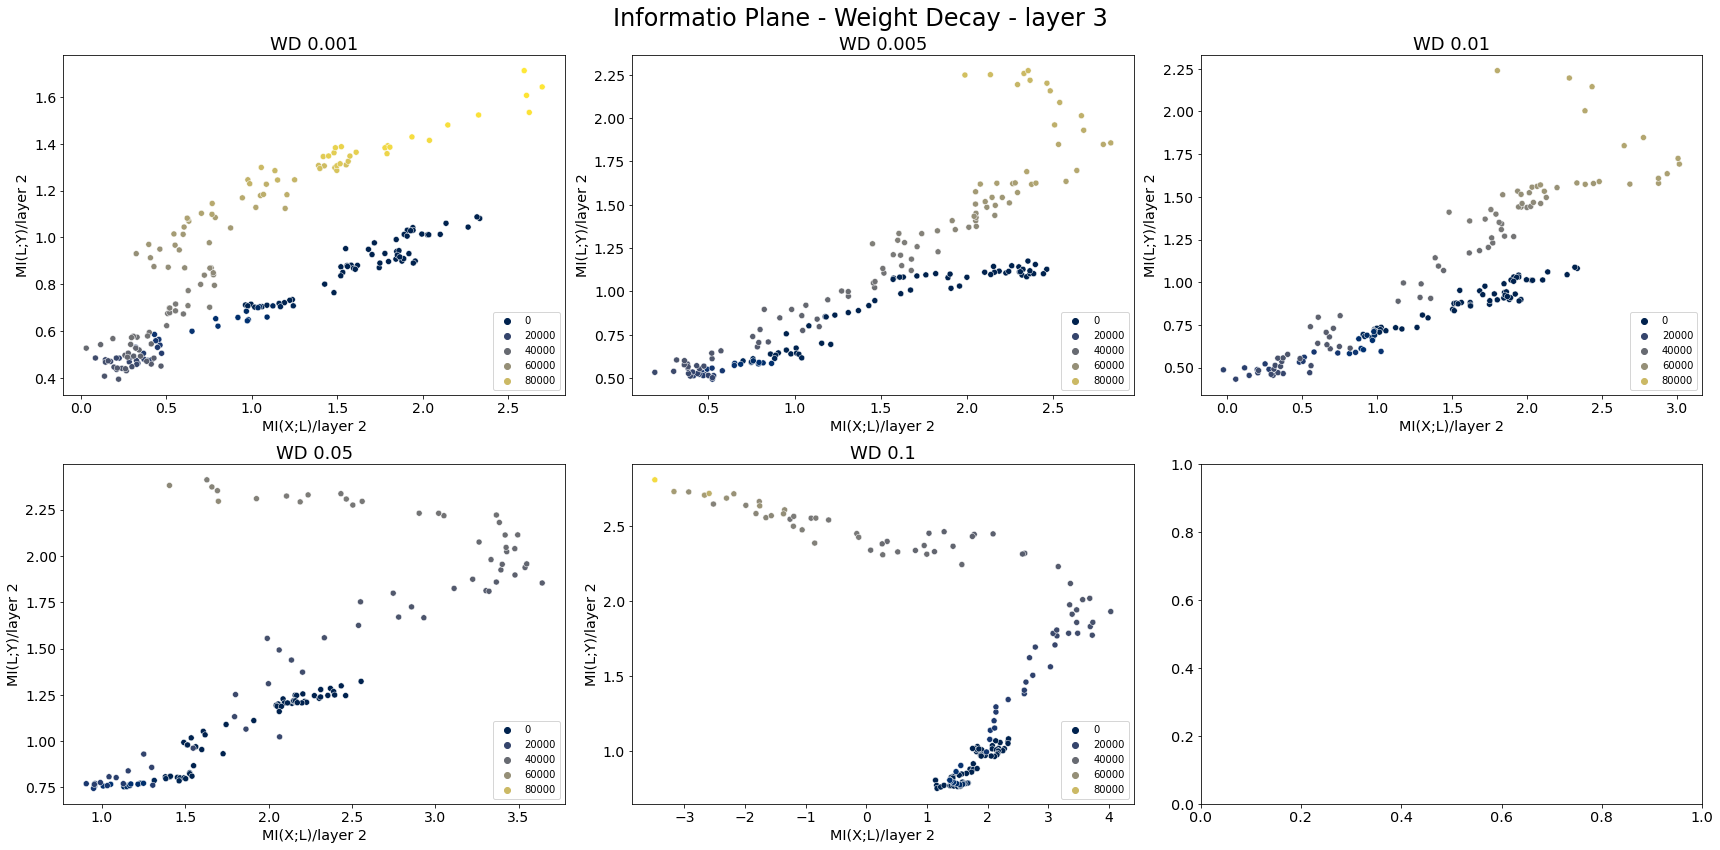

In [133]:
fig, axs2d = plt.subplots(2, 3, figsize=(12*2,6*2), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 2', 
        y=f'MI(L;Y)/layer 2',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"WD {df_name.split('_')[-1]}", fontsize=18)
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        axs_rav[plot_i].set_title(f"WD 0.01", fontsize=18)    
        
    
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Informatio Plane - Weight Decay - layer 3', fontsize=24)
plt.tight_layout()
plt.show()

### No hue - line

In [134]:
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 1'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 1'].values
# )
# plt.show()
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 2'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 2'].values
# )
# plt.show()
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 3'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 3'].values
# )
# plt.show()


### Loss

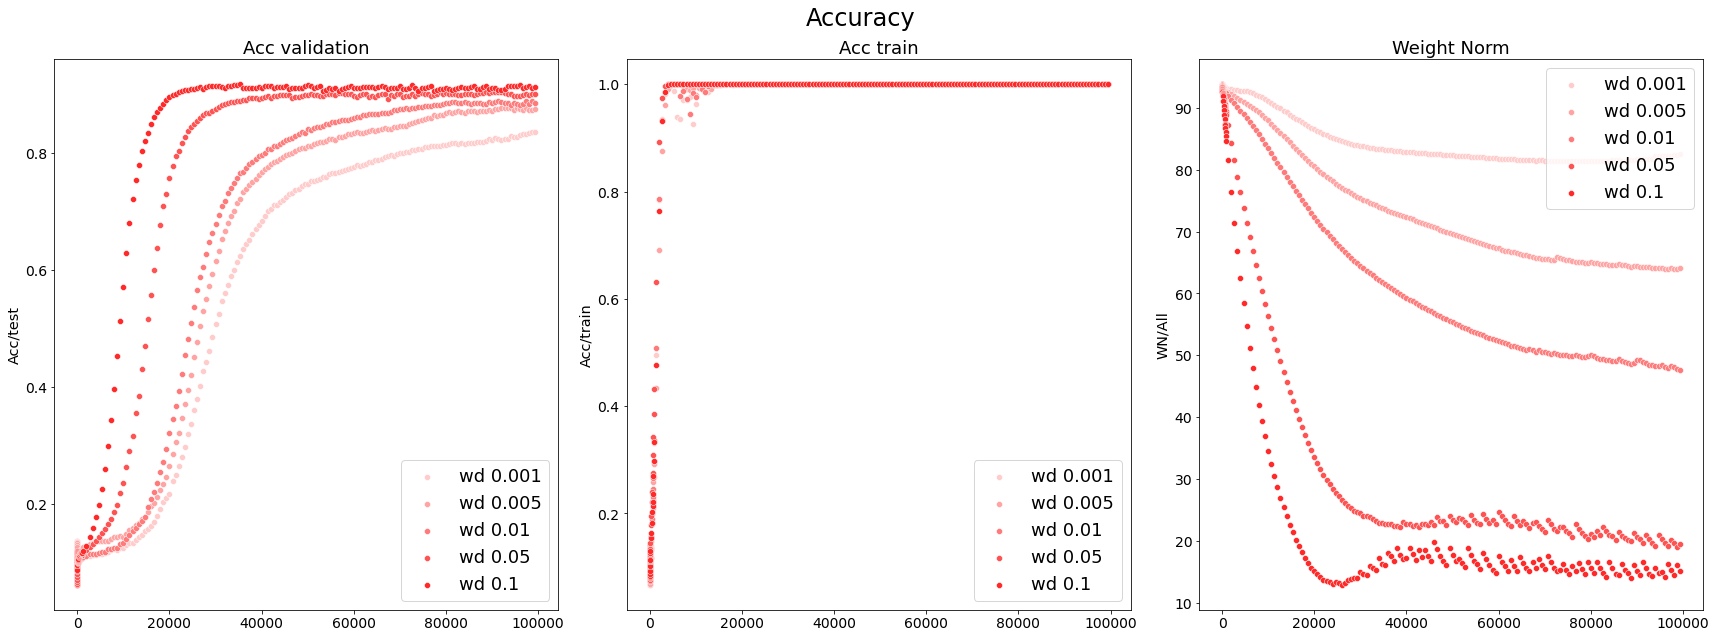

In [138]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,9), )

axs_rav = np.ravel(axs2d)

rgb_0 = (255/255, 0, 0)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        label_=f"wd 0.01"
    else:
        label_=f"wd {df_name.split('_')[-1]}"
             
    hue_i = 5-plot_i
    rgb_i = ( rgb_0[0], 0.8*hue_i/5, 0.8*hue_i/5)
    plot_i = 0
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="Acc/test",
        ax=axs_rav[0],
        color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=18)
    axs_rav[plot_i].set_title(f"Acc validation", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="Acc/train",
        ax=axs_rav[1],
        color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=18)
    axs_rav[plot_i+1].set_title(f"Acc train", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="WN/All",
        ax=axs_rav[2],
        color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='upper right', fontsize=18)
    axs_rav[plot_i+2].set_title(f"Weight Norm", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('Accuracy', fontsize=24)
plt.tight_layout()
plt.show()

## MI over steps

### mi x l

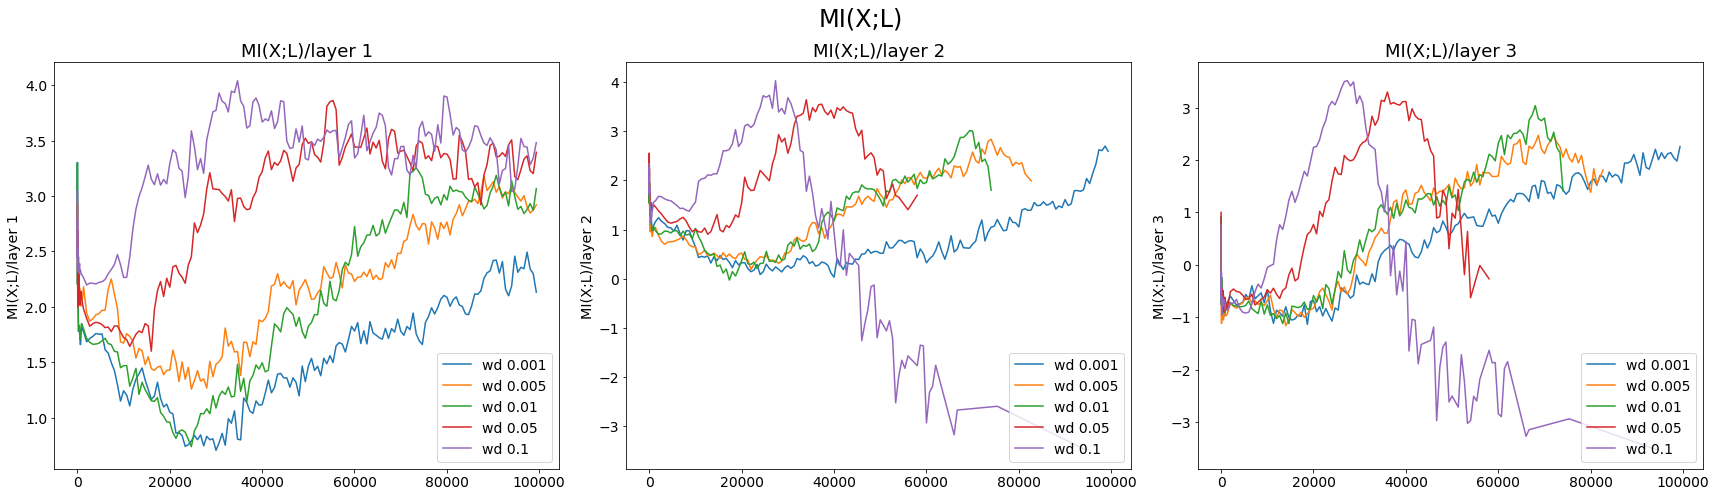

In [136]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,7), )

axs_rav = np.ravel(axs2d)

rgb_0 = (0, 166/255, 255/255)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        label_=f"wd 0.01"
    else:
        label_=f"wd {df_name.split('_')[-1]}"
             
    hue_i = 8-plot_i
    rgb_i = (0.8*hue_i/8 , rgb_0[1]+89/255*hue_i/8, rgb_0[2])
    plot_i = 0
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 1",
        ax=axs_rav[0],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i].set_title(f"MI(X;L)/layer 1", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 2",
        ax=axs_rav[1],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+1].set_title(f"MI(X;L)/layer 2", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 3",
        ax=axs_rav[2],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+2].set_title(f"MI(X;L)/layer 3", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('MI(X;L)', fontsize=24)
plt.tight_layout()
plt.show()

###  mi l y 

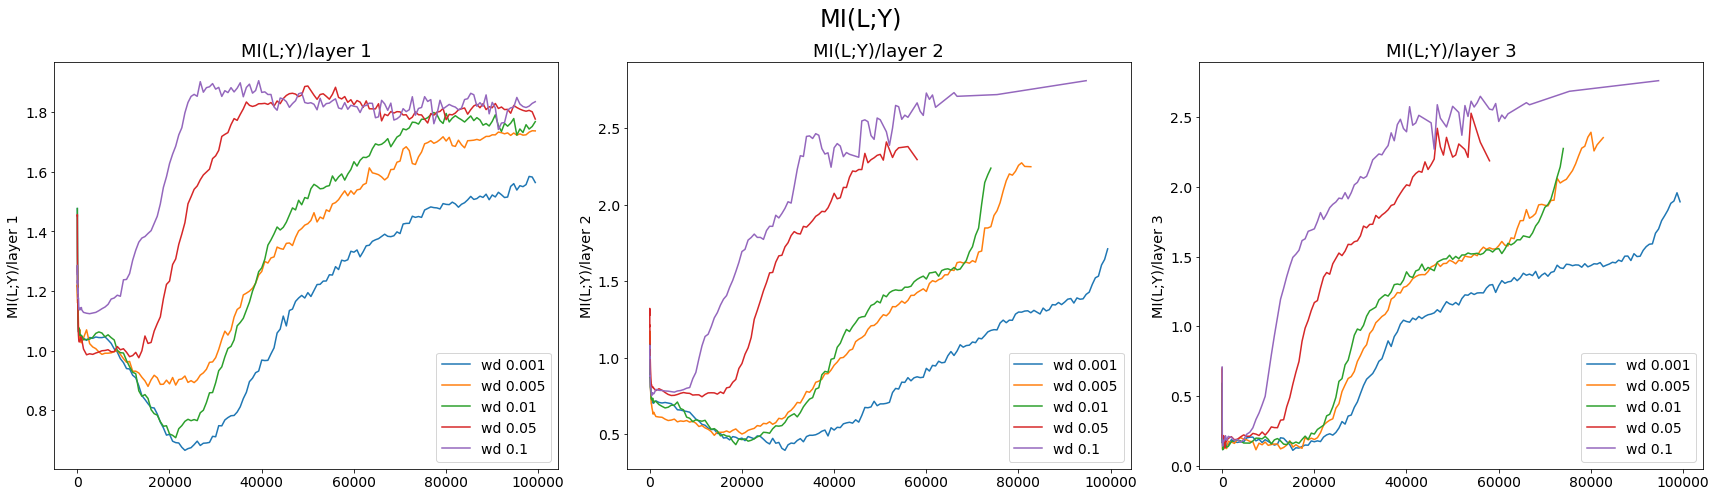

In [137]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,7), )

axs_rav = np.ravel(axs2d)

rgb_0 = (0, 166/255, 255/255)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        label_=f"wd 0.01"
    else:
        label_=f"wd {df_name.split('_')[-1]}"
             
    hue_i = 8-plot_i
    rgb_i = (0.8*hue_i/8 , rgb_0[1]+89/255*hue_i/8, rgb_0[2])
    plot_i = 0
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 1",
        ax=axs_rav[0],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i].set_title(f"MI(L;Y)/layer 1", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 2",
        ax=axs_rav[1],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+1].set_title(f"MI(L;Y)/layer 2", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 3",
        ax=axs_rav[2],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+2].set_title(f"MI(L;Y)/layer 3", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('MI(L;Y)', fontsize=24)
plt.tight_layout()
plt.show()

# Plots - LR 

In [172]:
log_folders = {}

prefixes = {}
prefixes['lr'] = "v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR"

log_folders['lr'] = [dir_ for dir_ in os.listdir(logs_dir) if dir_.startswith(prefixes['lr'])]

In [173]:
log_folders['lr'] = log_folders['lr']

In [174]:
log_folders['lr']

['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.0001',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.0004',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.0008',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.002',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.006',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR_0.01']

In [175]:
events_dd = {}

for filename in log_folders['lr']:
    filepath = os.path.join(logs_dir, filename)
    filepath_plus = os.path.join(filepath, os.listdir(os.path.join(logs_dir, filename))[0])
    events_dd[filename] = EventAccumulator(filepath_plus)
    
for event_acc in events_dd.values():
    event_acc.Reload();
    
cols_df = next(iter(events_dd.values())).Tags()['scalars']
cols_df

logs_dd = {}
logs_df = {}

for name, event in events_dd.items():
    logs_dd[name] = {}
    for col_ in cols_df:
        logs_dd[name][col_] = list(map(lambda x: x.value, event.Scalars(col_)))
        
for key, val in logs_dd.items():
    reval = {}
    for k, v in val.items():
        if not k.startswith('MI-Errors'):
            reval[k] = v
    logs_df[key] = pd.DataFrame(data=reval)

In [176]:
import matplotlib.pylab as pylab
params = {
#     'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

##  Planes

In [177]:
df_plot

Loss/train     Loss/test  Acc/train  Acc/test     WN/All  \
0    36974.031250  40452.378906      0.092    0.1084  93.643448   
1    33231.832031  33359.824219      0.109    0.1184  93.694939   
2     7999.336914   8465.319336      0.077    0.0790  93.754646   
3     6700.903809   7094.712891      0.104    0.1070  93.843590   
4     5825.663574   6374.645508      0.087    0.1011  93.940407   
..            ...           ...        ...       ...        ...   
197      0.096149      0.448112      0.947    0.7521  38.082680   
198      0.027129      0.458848      0.984    0.7539  38.305412   
199      0.075988      0.507838      0.974    0.7411  37.465088   
200      0.019776      0.462165      0.987    0.7557  36.918438   
201      0.021694      0.451521      0.986    0.7606  35.562840   

     WN/Last layer  MI(X;L)/layer 1  MI(L;Y)/layer 1  MI(X;L)/layer 2  \
0        65.457344         2.788370         1.256923         2.332202   
1        65.463890         2.895890         1.278115         2.166372   
2        65.462555         2.653771         1.231120         2.314470   
3        65.469078         2.273900         1.169985         2.270998   
4        65.479347         2.217719         1.166512         2.269904   
..             ...              ...              ...              ...   
197       6.961947              NaN              NaN              NaN   
198       7.316174              NaN              NaN              NaN   
199       7.347682              NaN              NaN              NaN   
200       7.326882              NaN              NaN              NaN   
201       7.338302              NaN              NaN              NaN   

     MI(L;Y)/layer 2  MI(X;L)/layer 3  MI(L;Y)/layer 3  
0           1.063061         0.757589         0.707141  
1           1.075309         1.087066         0.648187  
2           1.093331         0.871118         0.611458  
3           1.072340         0.826885         0.647125  
4           1.077902         0.716730         0.666257  
..               ...              ...              ...  
197              NaN              NaN              NaN  
198              NaN              NaN              NaN  
199              NaN              NaN              NaN  
200              NaN              NaN              NaN  
201              NaN              NaN              NaN  

[202 rows x 12 columns]

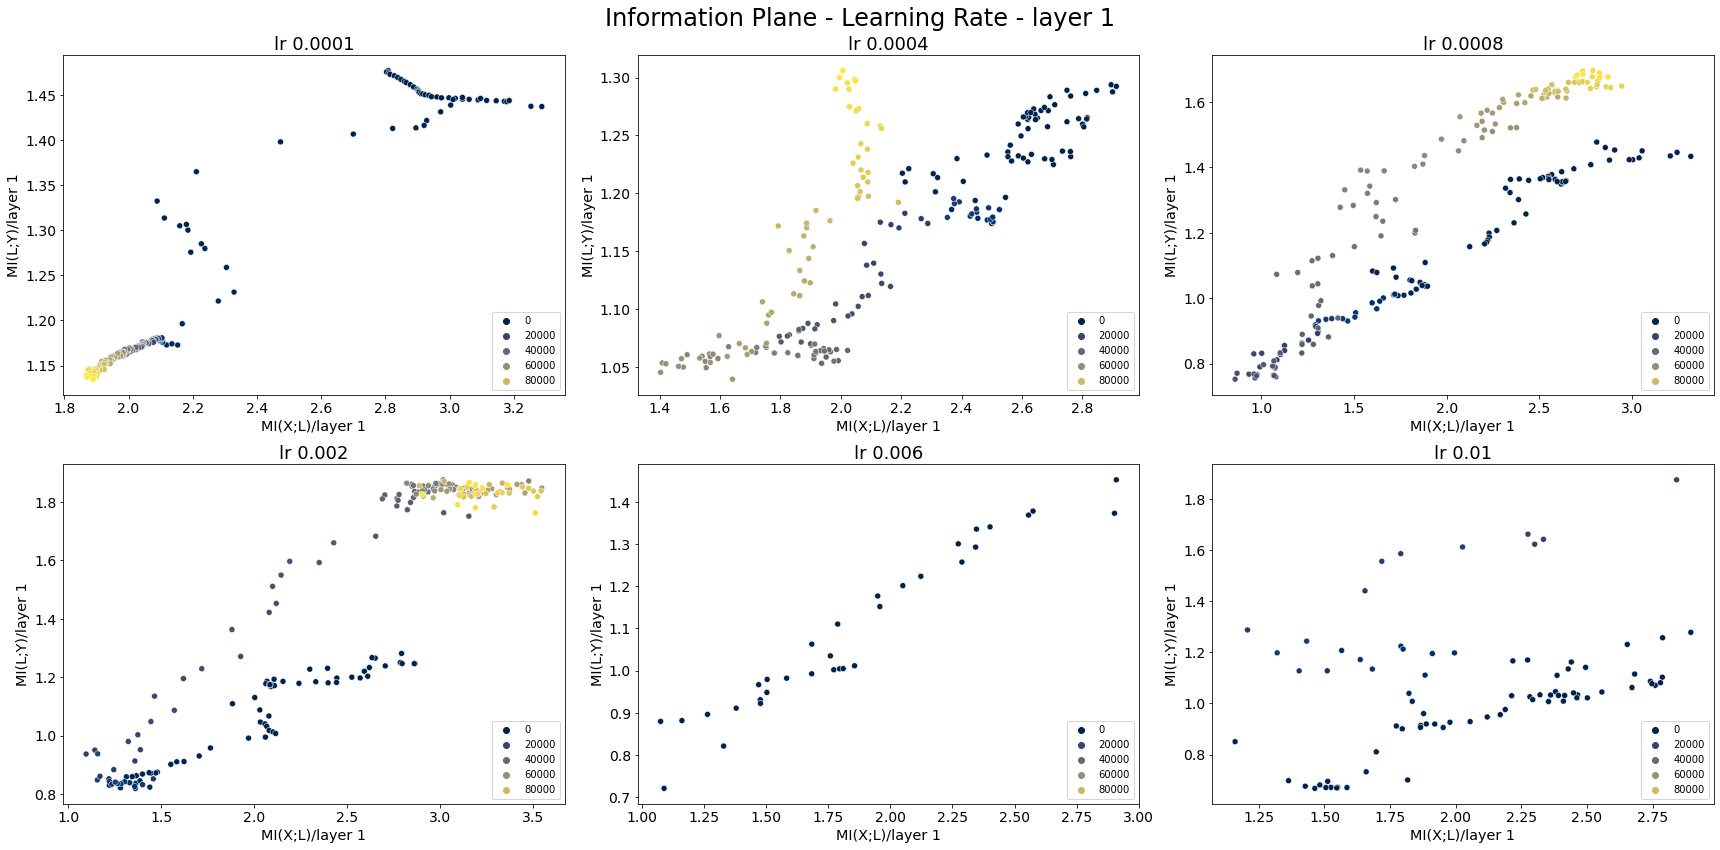

In [181]:
fig, axs2d = plt.subplots(2, 3, figsize=(12*2,6*2), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 1', 
        y=f'MI(L;Y)/layer 1',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"lr {df_name.split('_')[-1]}", fontsize=18)
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        axs_rav[plot_i].set_title(f"lr 0.001", fontsize=18)    
        
    
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Information Plane - Learning Rate - layer 1', fontsize=24)
plt.tight_layout()
plt.show()

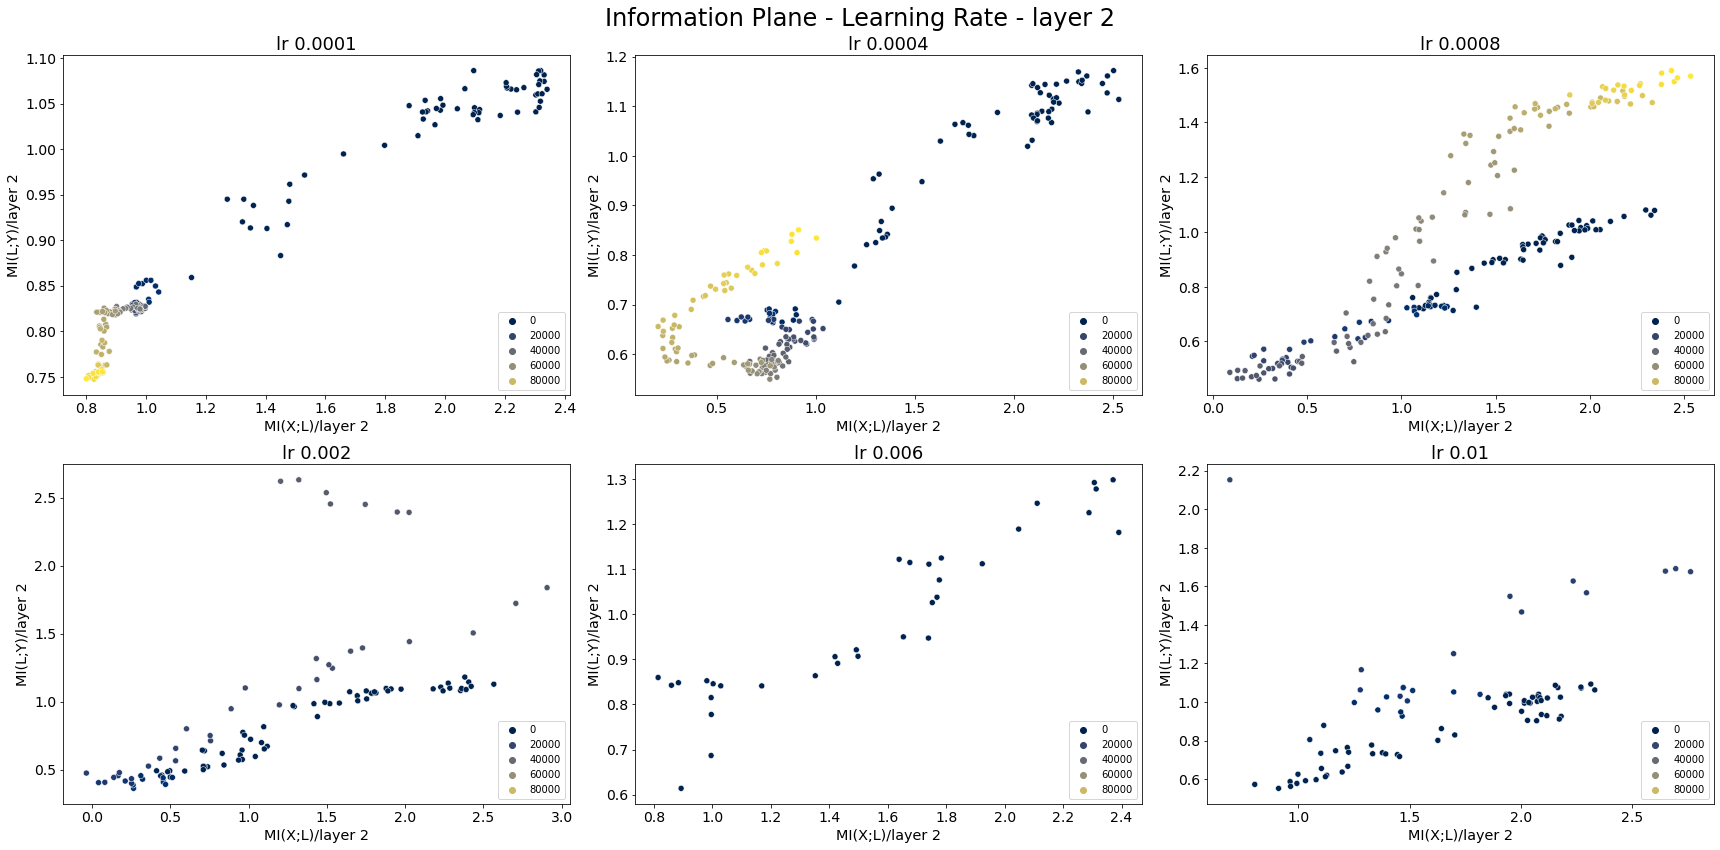

In [182]:
fig, axs2d = plt.subplots(2, 3, figsize=(12*2,6*2), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 2', 
        y=f'MI(L;Y)/layer 2',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"lr {df_name.split('_')[-1]}", fontsize=18)
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        axs_rav[plot_i].set_title(f"lr 0.001", fontsize=18)    
        
    
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Information Plane - Learning Rate - layer 2', fontsize=24)
plt.tight_layout()
plt.show()

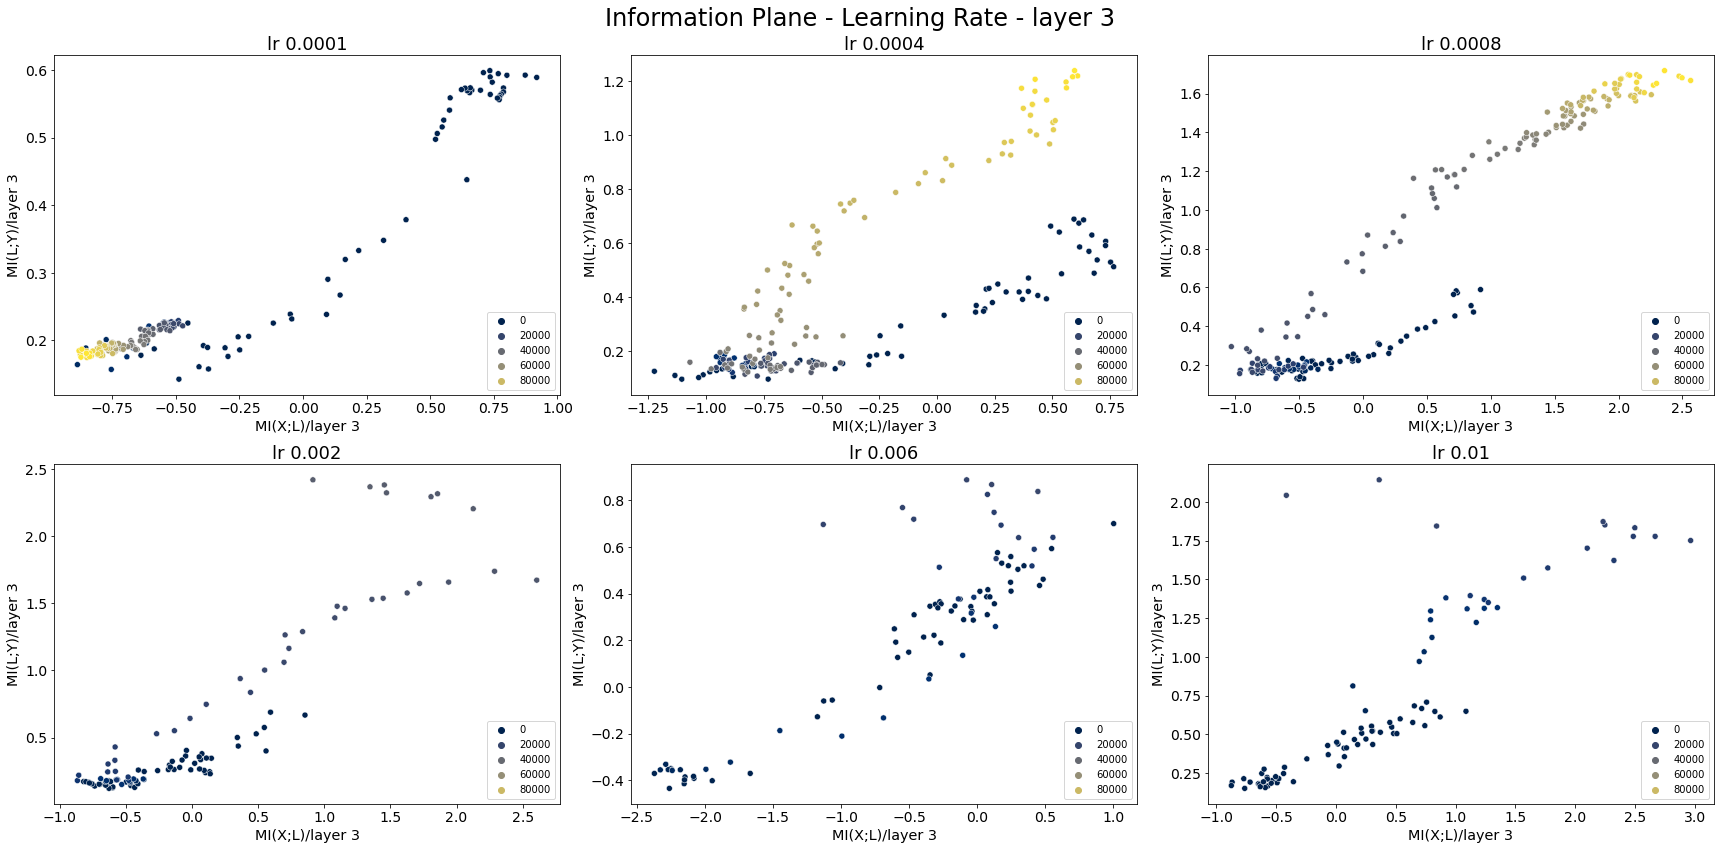

In [183]:
fig, axs2d = plt.subplots(2, 3, figsize=(12*2,6*2), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 3', 
        y=f'MI(L;Y)/layer 3',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"lr {df_name.split('_')[-1]}", fontsize=18)
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        axs_rav[plot_i].set_title(f"lr 0.001", fontsize=18)    
        
    
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Information Plane - Learning Rate - layer 3', fontsize=24)
plt.tight_layout()
plt.show()

### No hue - line

In [134]:
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 1'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 1'].values
# )
# plt.show()
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 2'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 2'].values
# )
# plt.show()
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 3'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 3'].values
# )
# plt.show()


### Loss

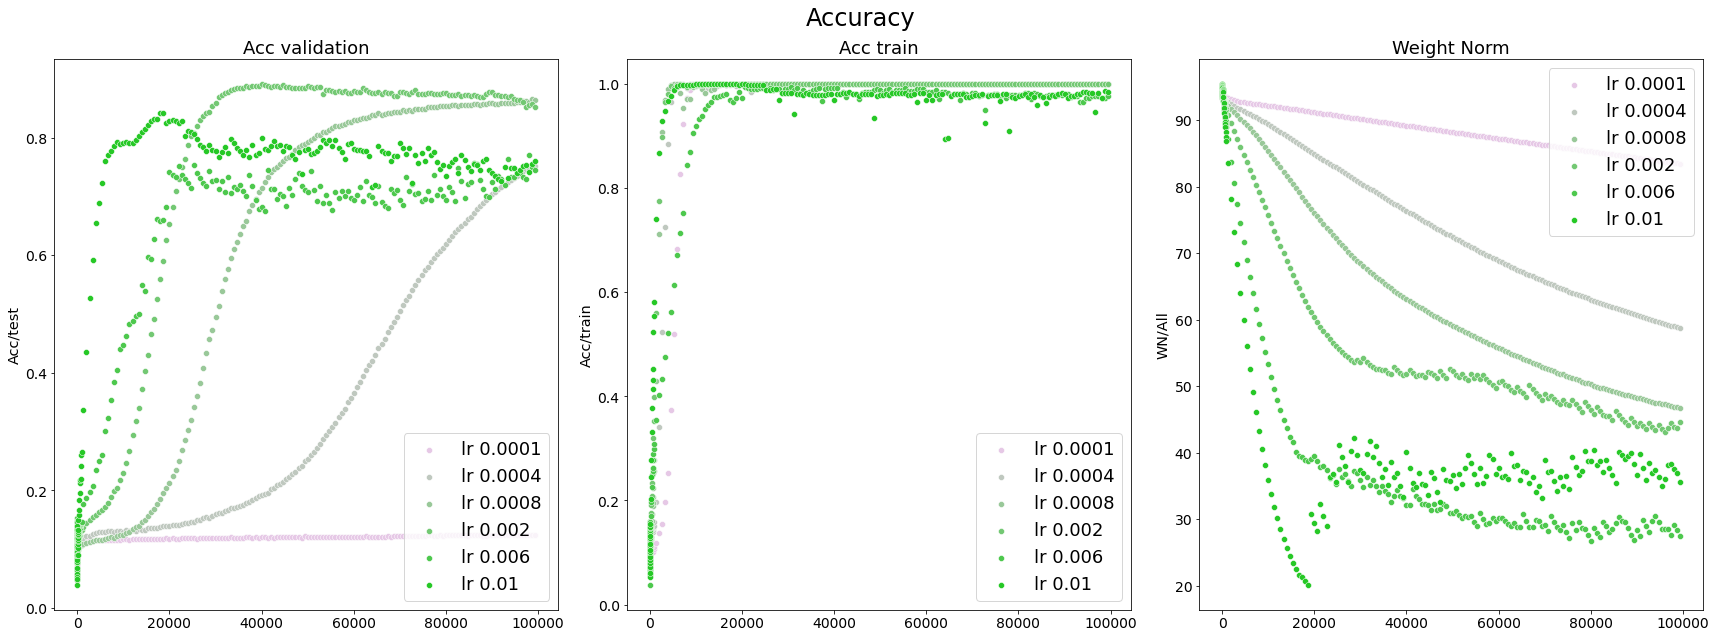

In [193]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,9), )

axs_rav = np.ravel(axs2d)

rgb_0 = ( 0, 200/255, 0)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        label_=f"lr 0.01"
    else:
        label_=f"lr {df_name.split('_')[-1]}"
             
    hue_i = 6-plot_i
    rgb_i = (  0.9*hue_i/6, rgb_0[1], 0.9*hue_i/6)
    plot_i = 0
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="Acc/test",
        ax=axs_rav[0],
        color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=18)
    axs_rav[plot_i].set_title(f"Acc validation", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="Acc/train",
        ax=axs_rav[1],
        color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=18)
    axs_rav[plot_i+1].set_title(f"Acc train", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="WN/All",
        ax=axs_rav[2],
        color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='upper right', fontsize=18)
    axs_rav[plot_i+2].set_title(f"Weight Norm", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('Accuracy', fontsize=24)
plt.tight_layout()
plt.show()

## MI over steps

### mi x l

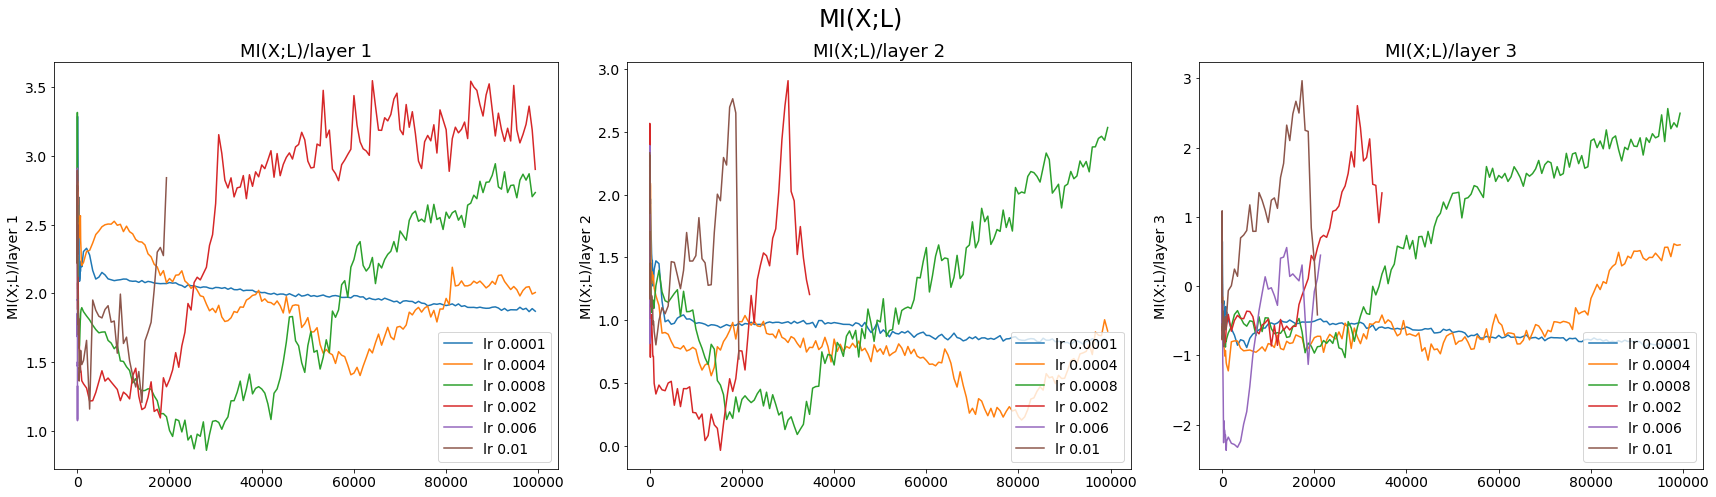

In [194]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,7), )

axs_rav = np.ravel(axs2d)

rgb_0 = ( 0, 200/255, 0)


for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        label_=f"lr 0.01"
    else:
        label_=f"lr {df_name.split('_')[-1]}"
             
    hue_i = 8-plot_i
    rgb_i = (0.8*hue_i/8 , rgb_0[1]+89/255*hue_i/8, rgb_0[2])
    plot_i = 0
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 1",
        ax=axs_rav[0],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i].set_title(f"MI(X;L)/layer 1", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 2",
        ax=axs_rav[1],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+1].set_title(f"MI(X;L)/layer 2", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 3",
        ax=axs_rav[2],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+2].set_title(f"MI(X;L)/layer 3", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('MI(X;L)', fontsize=24)
plt.tight_layout()
plt.show()

###  mi l y 

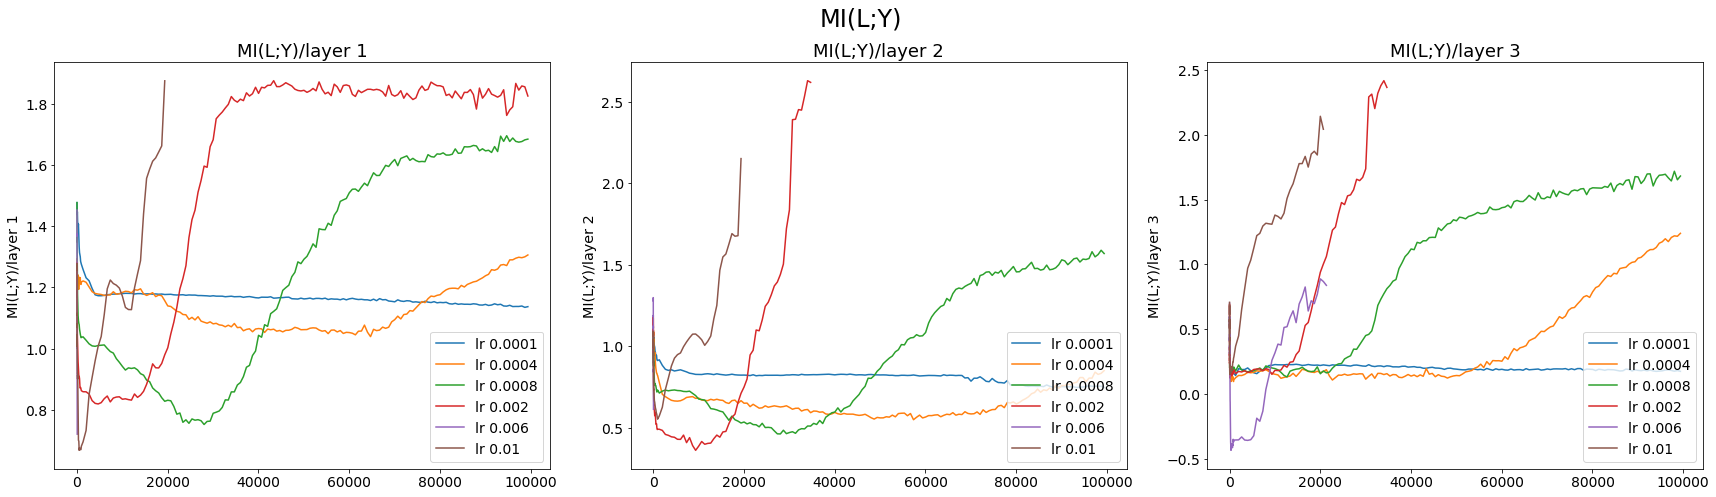

In [196]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,7), )

axs_rav = np.ravel(axs2d)

rgb_0 = (0, 166/255, 255/255)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        label_=f"lr 0.01"
    else:
        label_=f"lr {df_name.split('_')[-1]}"
             
    hue_i = 8-plot_i
    rgb_i = (0.8*hue_i/8 , rgb_0[1]+89/255*hue_i/8, rgb_0[2])
    plot_i = 0
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 1",
        ax=axs_rav[0],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i].set_title(f"MI(L;Y)/layer 1", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 2",
        ax=axs_rav[1],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+1].set_title(f"MI(L;Y)/layer 2", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 3",
        ax=axs_rav[2],
#         color = [rgb_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+2].set_title(f"MI(L;Y)/layer 3", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('MI(L;Y)', fontsize=24)
plt.tight_layout()
plt.show()

# Plots - Lion vs Default

In [237]:
log_folders = {}

# prefixes = {}
# prefixes['lr'] = "v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_LR"

# log_folders['lr'] = [dir_ for dir_ in os.listdir(logs_dir) if dir_.startswith(prefixes['lr'])]

log_folders['LION'] = ['v32-mlp3-wd1e-2-steps100k-trainpts1k-lr1e-3--ITER_OPTIMIZER_Lion', 
                      'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0' ]

In [238]:
log_folders['LION'] = log_folders['LION']

In [239]:
log_folders['LION']

['v32-mlp3-wd1e-2-steps100k-trainpts1k-lr1e-3--ITER_OPTIMIZER_Lion',
 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']

In [240]:
events_dd = {}

for filename in log_folders['LION']:
    filepath = os.path.join(logs_dir, filename)
    filepath_plus = os.path.join(filepath, os.listdir(os.path.join(logs_dir, filename))[0])
    events_dd[filename] = EventAccumulator(filepath_plus)
    
for event_acc in events_dd.values():
    event_acc.Reload();
    
cols_df = next(iter(events_dd.values())).Tags()['scalars']
cols_df

logs_dd = {}
logs_df = {}

for name, event in events_dd.items():
    logs_dd[name] = {}
    for col_ in cols_df:
        logs_dd[name][col_] = list(map(lambda x: x.value, event.Scalars(col_)))
        
for key, val in logs_dd.items():
    reval = {}
    for k, v in val.items():
        if not k.startswith('MI-Errors'):
            reval[k] = v
    logs_df[key] = pd.DataFrame(data=reval)

In [241]:
import matplotlib.pylab as pylab
params = {
#     'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

##  Planes

In [242]:
df_plot

Loss/train     Loss/test  Acc/train  Acc/test     WN/All  \
0    25600.066406  27642.009766      0.099    0.1104  93.799049   
1    15932.338867  17490.890625      0.112    0.1105  93.794083   
2    10143.050781  11239.863281      0.119    0.1104  93.790192   
3     7368.859863   8094.794922      0.135    0.1078  93.787010   
4     6569.389648   7038.325684      0.132    0.1102  93.783699   
..            ...           ...        ...       ...        ...   
197      0.000025      0.225234      1.000    0.8838  47.939381   
198      0.000007      0.214948      1.000    0.8878  48.243217   
199      0.000122      0.221465      1.000    0.8837  48.024780   
200      0.000139      0.218952      1.000    0.8878  47.842785   
201      0.000104      0.220352      1.000    0.8853  47.698471   

     WN/Last layer  MI(X;L)/layer 1  MI(L;Y)/layer 1  MI(X;L)/layer 2  \
0        65.651962         2.809109         1.476948         1.941562   
1        65.649887         2.875183         1.456946         2.264541   
2        65.648155         2.968731         1.451665         2.332443   
3        65.646553         3.213841         1.446679         2.316321   
4        65.644554         3.301424         1.434349         2.135383   
..             ...              ...              ...              ...   
197      28.137579         2.840595         1.731918              NaN   
198      28.165316         2.877790         1.758277              NaN   
199      28.037960         2.930773         1.743728              NaN   
200      27.926401         2.870778         1.752275              NaN   
201      27.820696         3.065673         1.768534              NaN   

     MI(L;Y)/layer 2  MI(X;L)/layer 3  MI(L;Y)/layer 3  
0           1.041975         0.918674         0.589181  
1           1.044203         0.769525         0.565089  
2           1.081154         0.673058         0.572834  
3           1.087721         0.697734         0.524514  
4           1.060406         0.820875         0.469112  
..               ...              ...              ...  
197              NaN              NaN              NaN  
198              NaN              NaN              NaN  
199              NaN              NaN              NaN  
200              NaN              NaN              NaN  
201              NaN              NaN              NaN  

[202 rows x 12 columns]

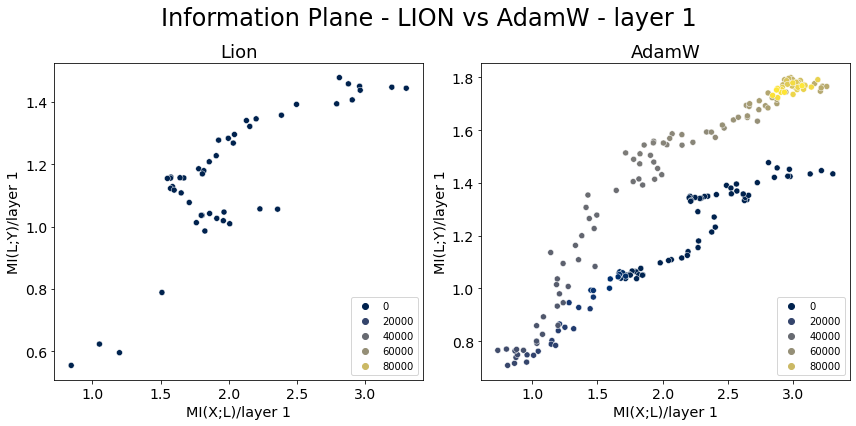

In [250]:
fig, axs2d = plt.subplots(1, 2, figsize=(12,6), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 1', 
        y=f'MI(L;Y)/layer 1',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"{df_name.split('_')[-1]}", fontsize=18)
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        axs_rav[plot_i].set_title(f"AdamW", fontsize=18)    
        
    
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Information Plane - LION vs AdamW - layer 1', fontsize=24)
plt.tight_layout()
plt.show()

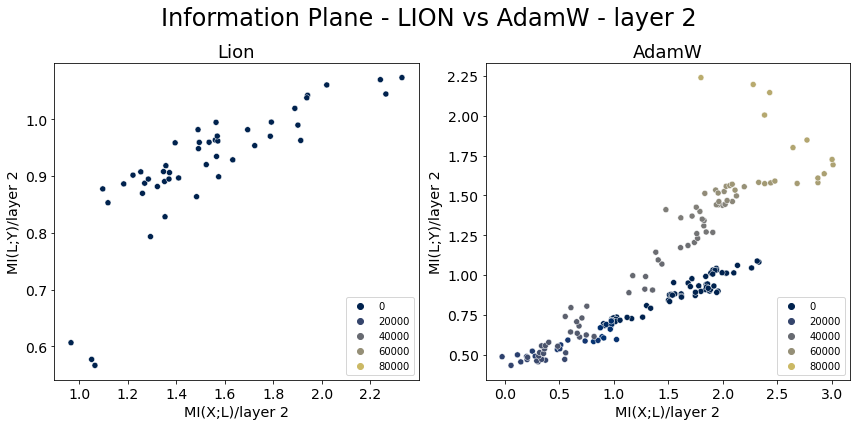

In [251]:
fig, axs2d = plt.subplots(1, 2, figsize=(12,6), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 2', 
        y=f'MI(L;Y)/layer 2',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"{df_name.split('_')[-1]}", fontsize=18)
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        axs_rav[plot_i].set_title(f"AdamW", fontsize=18)    
        
    
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Information Plane - LION vs AdamW - layer 2', fontsize=24)
plt.tight_layout()
plt.show()

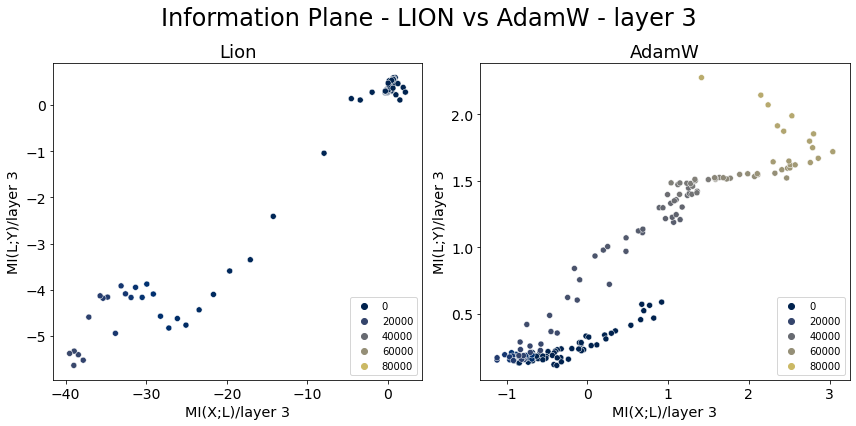

In [252]:
fig, axs2d = plt.subplots(1, 2, figsize=(12,6), )

axs_rav = np.ravel(axs2d)

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    
    sns.scatterplot(
        data=df_plot, 
        x=f'MI(X;L)/layer 3', 
        y=f'MI(L;Y)/layer 3',
        hue=steps,
        ax=axs_rav[plot_i],
        palette = 'cividis',
    )
    axs_rav[plot_i].legend(loc='lower right')
    axs_rav[plot_i].set_title(f"{df_name.split('_')[-1]}", fontsize=18)
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        axs_rav[plot_i].set_title(f"AdamW", fontsize=18)    
        
    
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
#     if plot_i < 4:
#         axs_rav[plot_i].set_xlim(1.4, 4)
#         axs_rav[plot_i].set_ylim(0.75, 2.4)
#     else:
#         axs_rav[plot_i].set_xlim(0.5, 3.5)
#         axs_rav[plot_i].set_ylim(0.5, 2.)


    
fig.suptitle('Information Plane - LION vs AdamW - layer 3', fontsize=24)
plt.tight_layout()
plt.show()

### No hue - line

In [246]:
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 1'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 1'].values
# )
# plt.show()
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 2'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 2'].values
# )
# plt.show()
# plt.plot(
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(X;L)/layer 3'].values,
#     logs_df['v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0']['MI(L;Y)/layer 3'].values
# )
# plt.show()


### Accs

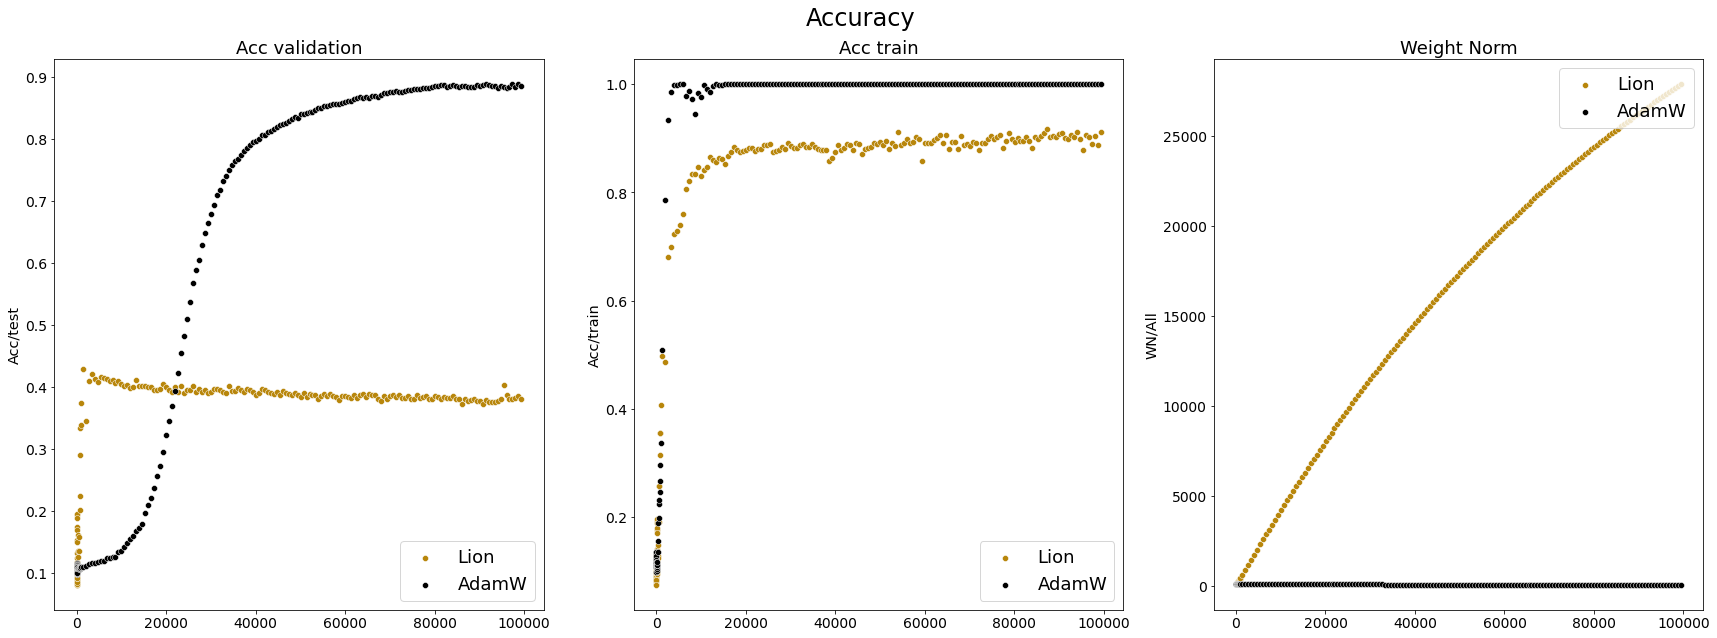

In [247]:
fig, axs2d = plt.subplots(1, 3, figsize=(12*2,9), )

axs_rav = np.ravel(axs2d)

rgb_0 = ( 255/255, 255/255, 255/255)
colors__ = ['darkgoldenrod', 'black']

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        label_=f"AdamW"
    else:
        label_=f"{df_name.split('_')[-1]}"
             
    color_i = plot_i
    plot_i = 0
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="Acc/test",
        ax=axs_rav[0],
        color = colors__[color_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=18)
    axs_rav[plot_i].set_title(f"Acc validation", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="Acc/train",
        ax=axs_rav[1],
        color = colors__[color_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=18)
    axs_rav[plot_i+1].set_title(f"Acc train", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.scatterplot(
        data=df_plot, 
        x=steps, 
        y="WN/All",
        ax=axs_rav[2],
        color = colors__[color_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='upper right', fontsize=18)
    axs_rav[plot_i+2].set_title(f"Weight Norm", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('Accuracy', fontsize=24)
plt.tight_layout()
plt.show()

## MI over steps

### mi x l

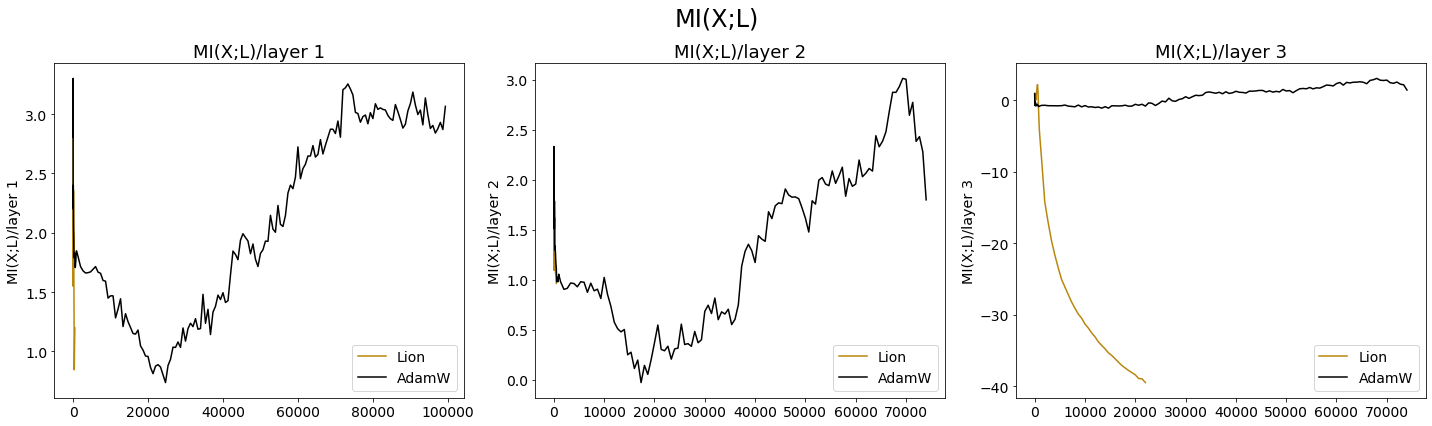

In [248]:
fig, axs2d = plt.subplots(1, 3, figsize=(10*2,6), )

axs_rav = np.ravel(axs2d)


colors__ = ['darkgoldenrod', 'black']

for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        label_=f"AdamW"
    else:
        label_=f"{df_name.split('_')[-1]}"
    
    color_i = plot_i
    plot_i = 0
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 1",
        ax=axs_rav[0],
        color = colors__[color_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i].set_title(f"MI(X;L)/layer 1", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 2",
        ax=axs_rav[1],
        color = colors__[color_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+1].set_title(f"MI(X;L)/layer 2", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(X;L)/layer 3",
        ax=axs_rav[2],
        color = colors__[color_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+2].set_title(f"MI(X;L)/layer 3", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('MI(X;L)', fontsize=24)
plt.tight_layout()
plt.show()

###  mi l y 

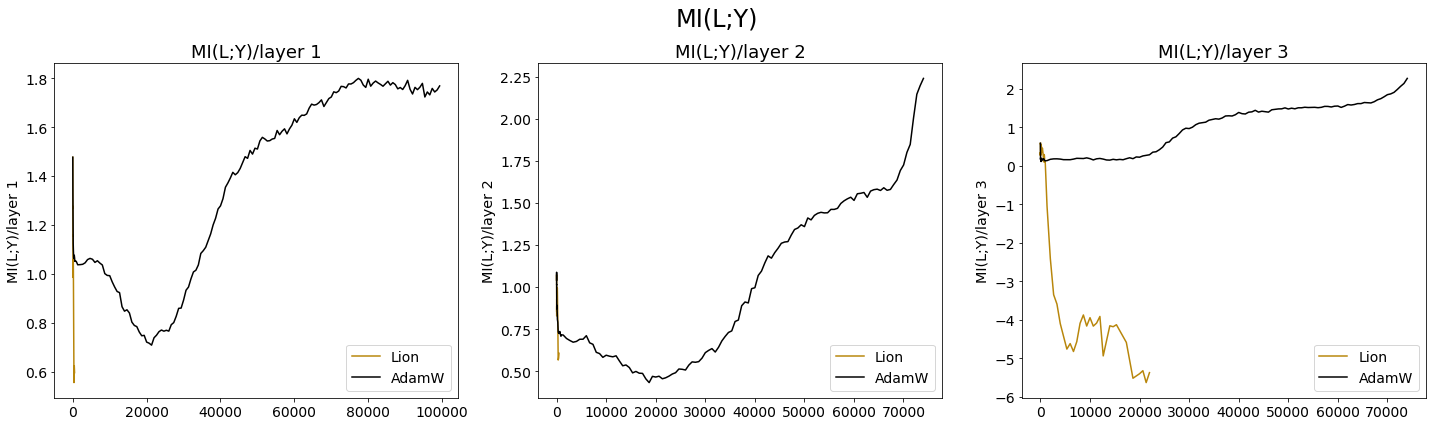

In [249]:
fig, axs2d = plt.subplots(1, 3, figsize=(10*2,6), )

axs_rav = np.ravel(axs2d)

colors__ = ['darkgoldenrod', 'black']


for plot_i, (df_name, df_plot) in enumerate(logs_df.items()):
    if df_name == 'v32-mlp3-wd1e-2-steps100k-trainpts1k--ITER_ALPHA_8.0':
        label_=f"AdamW"
    else:
        label_=f"{df_name.split('_')[-1]}"
             
    color_i = plot_i
    plot_i = 0
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 1",
        ax=axs_rav[0],
        color = colors__[color_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i].set_title(f"MI(L;Y)/layer 1", fontsize=18)
    axs_rav[plot_i].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 2",
        ax=axs_rav[1],
        color = colors__[color_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+1].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+1].set_title(f"MI(L;Y)/layer 2", fontsize=18)
    axs_rav[plot_i+1].tick_params(axis='both', which='major', labelsize=14)
    
    
    sns.lineplot(
        data=df_plot, 
        x=steps, 
        y="MI(L;Y)/layer 3",
        ax=axs_rav[2],
        color = colors__[color_i],
        label=label_
#         hue= float(df_name.split('_')[-1]),
#         label=f"Acc/test",
    )
    axs_rav[plot_i+2].legend(loc='lower right', fontsize=14)
    axs_rav[plot_i+2].set_title(f"MI(L;Y)/layer 3", fontsize=18)
    axs_rav[plot_i+2].tick_params(axis='both', which='major', labelsize=14)


    
fig.suptitle('MI(L;Y)', fontsize=24)
plt.tight_layout()
plt.show()